In [ ]:
# jupyter nbconvert Hello,_Colaboartory.ipy
# conda install -c damianavila82 rise # 슬라이드쇼 alt+R로 실행가능함

In [1]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정
# %matplotlib notebook
# %matplotlib ipympl
%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
# mpl.use('nbagg')
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc


#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import pandas_profiling as pdp

# 데이터 불러오기

In [4]:
#전체기후날씨데이터(weather.csv) 불러오기--------------------------
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

original = pd.read_csv('data.csv')

C:\Users\creal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (6,7,8,10,12,13,14,15,18,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# ★ 함수선언 ------------------------------------------------------
#-------날씨요소기준// 날짜-스테이션 데이터 도출함수
def weather_pivot(column_name):

    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 스테이션별 피봇팅(테이블)
    station_value = station_itm.pivot("date","station_nbr",column_name)
    station_table = station_value.apply(pd.to_numeric, errors = 'coerce')

    return station_table
    

#--------날씨요소기준// 날짜별 스테이션(숫자형)날씨요소 평균 도출함수---------
def weather_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["date","station_nbr",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
    avg_df = avg_df.apply(pd.to_numeric, errors = 'ignore')

    return avg_df


#--------날씨요소기준// 스테이션-전체날짜 날씨요소평균 도출함수---------
def station_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    station_avg = station_itm.pivot_table(column_name,["station_nbr"], aggfunc=np.mean)
    station_avg = station_avg.apply(pd.to_numeric, errors = 'ignore')
    
    return station_avg

#=============================================================================

#------★★완전체 형변환 함수(M,T,__T,None)==> 있는열도 변환 가능
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            continue 
        df = df.replace(["M",None],np.NaN)
        df = df.replace(["T","  T"],0.005)
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df



In [ ]:
#사용할 데이터 선택1 : 전체데이터=============================================================================
weather_p = type_change_numeric(weather,["station_nbr","codesum","date"])
weather_p["date"] = pd.to_datetime(weather_p["date"])
weather_p["tdelta"] = weather_p["tmax"]-weather_p["tmin"]

ls = ['TS', 'GR', 'RA', 'DZ', 'SN',
       'SG', 'GS', 'PL', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'DU', 'SQ', 'FZ',
       'MI', 'PR', 'BC', 'BL', 'VC']

for i in ls:
    weather_p[i] = (weather_p['codesum'].str.contains(i)== 1).astype(int)
    
store_df = store_data 
    
import time

store_df["date"] = pd.to_datetime(store_df["date"])
weather_p["date"] = pd.to_datetime(weather_p["date"])


result_df = store_df.merge(map_key, left_on="store_nbr", right_on="store_nbr" )
cols = ['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units']
new_df = result_df[cols] #열 위치변경된 것들
#- 2. 종합세팅
all_set = new_df.merge(weather_p, left_on=["date","station_nbr"], right_on=["date","station_nbr"] )

all_set["date"]=all_set["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
temp_df = type_change_numeric(all_set,["date","store_nbr","item_nbr","units","station_nbr","codesum"])

master = all_set.sort_values(["date","store_nbr","item_nbr"])

master['year'] = master['date'].dt.year
master['month'] = master['date'].dt.month
master['day'] = master['date'].dt.day
master['week_day_name']= master['date'].dt.weekday_name
master['SS']= (master['month']//3)%4 



In [ ]:
# 스토어별 아이템 판매현환 (0인곳 판별)
store_item = new_df.pivot_table("units","store_nbr","item_nbr", aggfunc=np.sum)
# avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
store_item

In [5]:
#===================================================================================================
#사용할 데이터 선택2  : 0제거 데이터
original = original.iloc[:,1:]

In [6]:
#스테이션 배정됨 - 16~20번 할당
bright_bf = original[(original["station_nbr"]<40)&(original["station_nbr"]>0)]
# bright_bf

In [7]:
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            continue 
        df = df.replace(["M",None],np.NaN)
        df = df.replace(["T","  T"],0.005)
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df

df = type_change_numeric(bright_bf,["station_nbr","codesum","date"])

In [8]:
# 각 코드별 타입변경
df.iloc[:,22:] = df.iloc[:,22:].astype(int)
# df.iloc[:,22:]

In [9]:
# 스토어 번호로 할당된 스토어당 아이템 넘버 확인 및 갯수확인
ls = list(set(bright_bf["item_nbr"]))
ls.sort()
store_item = df.pivot_table("units","item_nbr","store_nbr", aggfunc=np.count_nonzero)
# avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
# store_item.astype(int)
cnt = 0
for i in ls:
    print('item_nbr :' ,i)
    print(store_item.loc[i].dropna())
    cnt += len(store_item.loc[i].dropna())
print("총 해야할갯수(최대) : ", cnt)

item_nbr : 1
store_nbr
36    303.0
Name: 1, dtype: float64
item_nbr : 2
store_nbr
3     269.0
26    371.0
28    244.0
Name: 2, dtype: float64
item_nbr : 3
store_nbr
43    258.0
Name: 3, dtype: float64
item_nbr : 4
store_nbr
45    185.0
Name: 4, dtype: float64
item_nbr : 5
store_nbr
2      874.0
3      888.0
7      925.0
8      915.0
9      944.0
10     886.0
13     924.0
15    1009.0
18     939.0
20     894.0
21     912.0
23     937.0
26     946.0
28     884.0
37    1009.0
40    1009.0
42     874.0
44     887.0
Name: 5, dtype: float64
item_nbr : 6
store_nbr
24    957.0
Name: 6, dtype: float64
item_nbr : 7
store_nbr
7    340.0
Name: 7, dtype: float64
item_nbr : 8
store_nbr
29    906.0
Name: 8, dtype: float64
item_nbr : 9
store_nbr
1      919.0
4      959.0
6      874.0
11     898.0
14     819.0
17     938.0
22     895.0
25    1010.0
27     894.0
31     946.0
32    1006.0
33     911.0
34     945.0
36     963.0
38     870.0
39     787.0
45     910.0
Name: 9, dtype: float64
item_nbr : 10
s

In [10]:
#weather_p에 사전정제자료 삽입(codesum은 추가정제필요)

df["date"] = pd.to_datetime(df["date"])
df["tdelta"] = df["tmax"]-df["tmin"]

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['DOW']= df['date'].dt.dayofweek
df['SS']= (df['month']//3)%4 

# df["year"] = df.date.dt.year
# df["month"] = df.date.dt.month
df["quarter"] = df.date.dt.quarter
df["week_day_name"] = df.date.dt.weekday_name
df["day_of_year"] = df.date.dt.dayofyear
df["date"] = pd.to_datetime(df["date"])


In [ ]:
# 아이템별 평균계수 삽입
# df_m = df.groupby(["store_nbr","item_nbr"]).mean()["units"].reset_index()
# df_m.columns = ["store_nbr","item_nbr","units_mean"]
# df = df.merge(df_m, left_on=["store_nbr","item_nbr"], right_on=["store_nbr","item_nbr"], how='inner')

In [11]:
#윤년추가
# for idx in range(4,17 + 1):
#     item105.iloc[:,idx].fillna(item105.groupby(["day_of_year","store_nbr"])[item105.columns[idx]].\
#                               transform('mean'), inplace=True)


#depart에 tavg - tavg평균을 넣어주는 함수
def add_depart1(x):
    x.depart.fillna(x.tavg - x.groupby(["day_of_year","store_nbr"])["tavg"].transform('mean'),inplace = True)
    x.depart = x.depart.round(2)
    return x.sort_values(["store_nbr","date","item_nbr"])

add_depart1(df)



#미쿡공휴일 넣기
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = pd.DataFrame()
holidays = cal.holidays("2012","2015")

df["holiday"] = sum([df["date"] == i for i in holidays]) 

#블랙프라이데이 세일기간(11월21~11월30일)
df["BF_SS"] = ((df['month']==11)&(df['day']>=21)&(df['day']<31)).astype(int) 

#블랙프라이데이 당일
blackfriday = pd.to_datetime(['2012-11-23','2013-11-22','2014-11-28'])
df["BF_day"] = sum([df["date"] == i for i in blackfriday]) 


# item105.tmax.fillna(item105.groupby(["day_of_year","store_nbr"])['tmax'].transform('mean'), inplace=True) 

In [12]:
# df['mon'] = (df['DOW']==0).astype(int)
# df['tue'] = (df['DOW']==1).astype(int)
# df['wed'] = (df['DOW']==2).astype(int)
# df['thr'] = (df['DOW']==3).astype(int)
# df['fri'] = (df['DOW']==4).astype(int)
# df['sat'] = (df['DOW']==5).astype(int)
# df['sun'] = (df['DOW']==6).astype(int)
# df['wend'] = (df['DOW']>=5).astype(int)

df['weekend1'] = 0
df.weekend1[df['week_day_name'] == 'Sunday'] = 1
df.weekend1[df['week_day_name'] == 'Saturday'] = 1


df['weekend2'] = 0
df.weekend2[df['week_day_name'] == 'Saturday'] = 1
df.weekend2[df['week_day_name'] == 'Sunday'] = 1
df.weekend2[df['week_day_name'] == 'Friday'] = 1

df['weekend3'] = 0
df.weekend3[df['week_day_name'] == 'Saturday'] = 1
df.weekend3[df['week_day_name'] == 'Monday'] = 1
df.weekend3[df['week_day_name'] == 'Sunday'] = 1


C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\creal\Anaconda3\lib\site-package

In [13]:
# 특정조건열 추가 (0, 0.2 , 0.5 , 1 , 3 5단계로 강우량 단계 설정)
df['hardrain'] = [(((4 if i > 3 else 3) if i > 1 else 2) if i > 0.5 else 1) if i > 0.1 else 0 for i in df['preciptotal']]

# 득정조건열 추가 ()
df['hardsnow'] = [(((4 if i > 3 else 3) if i > 2 else 2) if i > 1 else 1) if i > 0.2 else 0 for i in df['snowfall']]

# len(df[df['snowfall']>=0.2])

In [14]:
# 표준편차계산
df['log_units'] = np.log(df['units']+1)
std_df = df.groupby(["store_nbr","item_nbr"]).std().log_units.reset_index()
std_df.columns = ["store_nbr", "item_nbr", "log_units_std"]

In [15]:
# 평균계산
mean_df = df.groupby(["store_nbr","item_nbr"]).mean().log_units.reset_index()
mean_df.columns = ["store_nbr", "item_nbr", "log_units_mean"]

In [16]:
# 전체데이터에 병합
data_add_std = pd.merge(df, std_df, on = ["store_nbr", "item_nbr"])
data_add_std_mean = pd.merge(data_add_std, mean_df, on = ["store_nbr", "item_nbr"])
data_add_std_mean["z_log_units"] = (data_add_std_mean.log_units - data_add_std_mean.log_units_mean).div(data_add_std_mean.log_units_std)

In [17]:
df=data_add_std_mean
# 표준편차가 -2이하로 떨어지면서 units가 0인것 표시
df["z_under-2"] = 0
df["z_under-2"] = ((df["units"]==0)&(df["z_log_units"]<=-2)&(df["log_units_mean"]>2)).astype(int)

# len(df[(df["log_units_mean"]>2)&(af["z_log_units"]>-6)&(df["z_under-2"]==1)])

# log units 의 정규성 보기

In [33]:
# df_t = cutForeBehindPeriod(df)
df_t=df

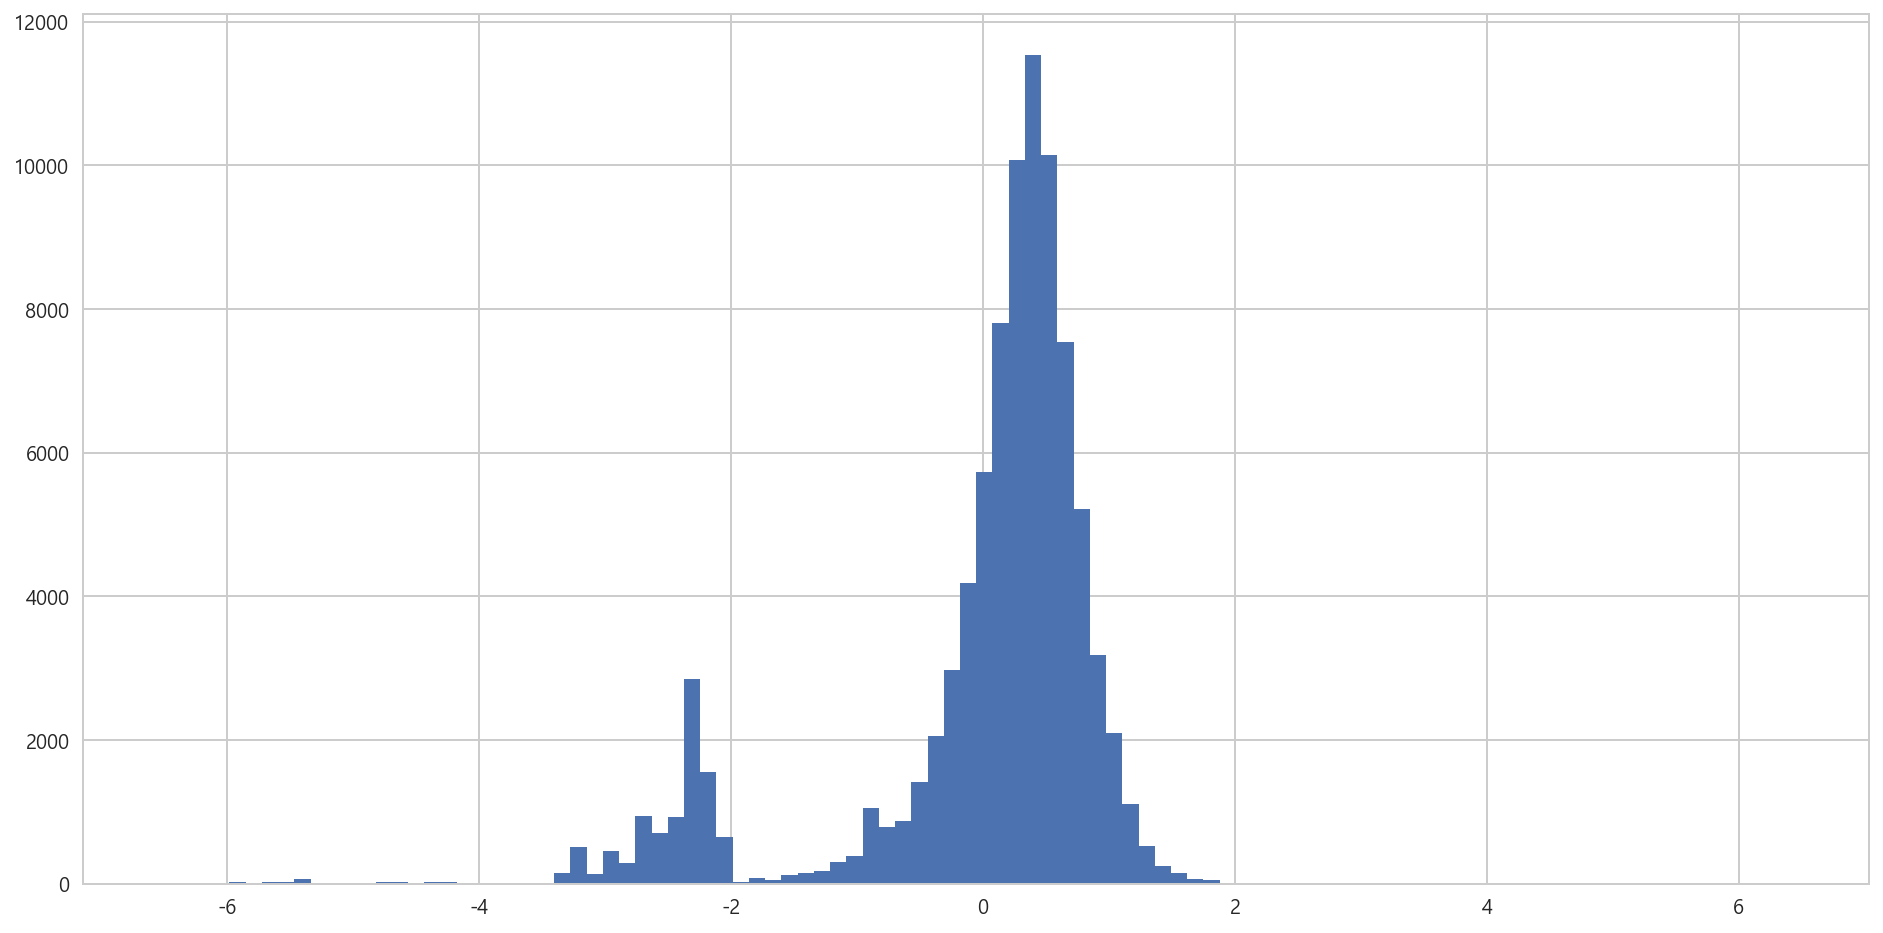

In [37]:
#기간순 log_units의 분포 (log_units<-2조건이면서 units==0인 경우 살색 )
af = df_t[(df_t["log_units_mean"]>2)&(df_t['date']!='2013-12-25')]#&(df_t["z_under-2"]==0)
# plt.figure(figsize=(16,8))
# plt.scatter(np.arange(len(af['log_units_mean'])),af["z_log_units"],c=af["z_under-2"])#c=af["z_under-2"]
# plt.show()
plt.figure(figsize=(16,8))
plt.hist(af["z_log_units"],bins=100)
plt.show()


# 평균적으로 10이상의 평균판매량을 보이는 것들중 조건 z값이 -2이하일때 units가 0인경우의 플롯


In [ ]:
len(df[(df["z_under-2"]==1)])

# 0. 비교플롯 함수화!! 

### 멀티박스플롯함수
- binary한 x변수에 따른 플롯테이블 작성 가능 

In [38]:
# 멀티박스플롯
def HVXY_multi_boxplot(df, Vcol, Xcol, Ycol, cutover=10000, cutlower=-1, Hlist=[], Vlist=[], plotsize=5):
    """This function show boxplot_table============ 

    df : 플롯팅을 할 데이터프레임 이름
    
    H : (Binomial,Carcinality)한 열, Cardinality가 4 이내 추천
    └----Hlist = 리스트형태로 cardinality한 컬럼들을 쓴다.
            예) ["FG","RA","SN","TS","FG+","mon","tue","wed"]
         Hcol = deleted
    
    V : (Cardinality)한 index로 쓸수있는 열
    └---- Vcol = index처럼 쓰일 수 있는 column_name을 쓴다
            예) "item_nbr","store_nbr","station_nbr" 사용가능
          Vlist = 위의 값들 중 특정 값을 찾기위해 쓴다.
          
    X : X축은 Cardinality한 값을 넣는다. 
    └---- Xcol = X축으로 사용할 cardinality한 column_name을 쓴다
    
    Y : Y축은 실수형 값을 넣을 수 있다. units등 각종 실수형,정수형 숫자
    └---- Ycol = Y축으로 사용항 실수형,정수형 column_name을 쓴다
    
    cutover : 지정된 값을 초과하는 Y축 데이터는 빼고 플롯팅한다.
    cutlower : 지정된 값보다 작은 Y축 데이터는 빼고 플롯팅한다.
    
    plotsize : 플롯의 사이즈를 지정할 수 있음(정수형)
    
    """

    print("HVXY running...")
    #일단 입력되는 리스트의 크기를 판별한다.
    vsize=len(Vlist)
    hsize=len(Hlist)
    fig = plt.figure(figsize=(plotsize*hsize,plotsize*vsize))
    cnt=0
    for i in range(vsize):
        temp = df[(df[Vcol]==Vlist[i])&(df[Ycol]<cutover)&(df[Ycol]>cutlower)]
        subplot_num = [int(str(vsize)+str(hsize)+str(cnt+k)) for k in range(1,hsize+1)]
        
        print(subplot_num)
        for j in range(hsize):
#             ax = fig.add_subplot(subplot_num[j])
            ax = plt.subplot2grid((vsize+1,hsize+1), (i,j))
            if i == 0:
                sns.boxplot(ax=ax, x=Xcol, y=Ycol, hue=Hlist[j], data=temp).set_title(Hlist[j])
            else : 
                sns.boxplot(ax=ax, x=Xcol, y=Ycol, hue=Hlist[j], data=temp)
            if j == 0 : ax.set_ylabel(str(Vcol)+":"+str(Vlist[i]))
        cnt += hsize
        
    print("plotting screen...", end="")
    plt.show()
    print("Complete!")
    
    return "plot success"


# HVXY_multi_boxplot(df,Vcol="item_nbr",Xcol="store_nbr",Ycol="units",cutover=2500, Hlist=["FG","RA","SN","TS"], Vlist=[15,16,37,44])


### 멀티스캐터플롯 함수
- continuous한 X변수에 따른 플롯테이블 생성

In [39]:
# 멀티reg플롯
def HVXY_multi_regplot(df, Hcol, Vcol, Xcol, Ycol, cutover=10000, cutlower=-1, Hlist=[], Vlist=[], plotsize=5):
    """This function show boxplot_table============ 

    df : 플롯팅을 할 데이터프레임 이름
    
    H : (Cardinality)한 index로 쓸수있는 열
    └---- Hcol = index처럼 쓰일 수 있는 column_name을 쓴다
            예) "item_nbr","store_nbr","station_nbr" 사용가능
          Hlist = 위의 값들 중 특정 값을 찾기위해 쓴다.
    
    V : (Cardinality)한 index로 쓸수있는 열
    └---- Vcol = index처럼 쓰일 수 있는 column_name을 쓴다
            예) "item_nbr","store_nbr","station_nbr" 사용가능
          Vlist = 위의 값들 중 특정 값을 찾기위해 쓴다.
          
    X : X축은 Continueous한 값을 넣는다. 
    └---- Xcol = X축으로 사용할 cardinality한 column_name을 쓴다
    
    Y : Y축은 실수형 값을 넣을 수 있다. units등 각종 실수형,정수형 숫자
    └---- Ycol = Y축으로 사용항 실수형,정수형 column_name을 쓴다
    
    cutover : 지정된 값을 초과하는 Y축 데이터는 빼고 플롯팅한다.
    cutlower : 지정된 값보다 작은 Y축 데이터는 빼고 플롯팅한다.
    
    plotsize : 플롯의 사이즈를 지정할 수 있음(정수형)
    
    """

    print("HVXY running...")
    #일단 입력되는 리스트의 크기를 판별한다.
    vsize=len(Vlist)
    hsize=len(Hlist)
    fig = plt.figure(figsize=(plotsize*hsize,plotsize*vsize))
    cnt=0
    for i in range(vsize):
        tmpA = df[(df[Vcol]==Vlist[i])&(df[Ycol]<cutover)&(df[Ycol]>cutlower)]
        subplot_num = [int(str(vsize)+str(hsize)+str(cnt+k)) for k in range(1,hsize+1)]
        print(subplot_num, end="")
        for j in range(hsize):
#             ax = fig.add_subplot(subplot_num[j])
            temp = tmpA[(tmpA[Hcol]==Hlist[j])]
            ax = plt.subplot2grid((vsize+1,hsize+1), (i,j))
            if i == 0:
#                 sns.distplot(ax=ax, x=Xcol, y=Ycol, data=temp, kde=True, rug=True).set_title(str(Hcol)+" : "+str(Hlist[j]))
#                 sns.lmplot(x=Xcol, y=Ycol, data=df, hue='DOW', fit_reg=True)
                try:
                    sns.regplot(ax=ax, x=Xcol, y=Ycol, data=temp).set_title(str(Hcol)+" : "+str(Hlist[j]))
                except:
                    ax.set_title(str(Hcol)+" : "+str(Hlist[j]))
                    print(', can`t plot-',Hlist[j], end="")
            else :
#                 sns.jointplot(ax=ax, x=Xcol, y=Ycol, data=temp)
#                 sns.lmplot(x=Xcol, y=Ycol, data=df, hue='FG', fit_reg=True)
                try:    
                    sns.regplot(ax=ax, x=Xcol, y=Ycol, data=temp)
                except:
                    print(', can`t plot-',Hlist[j], end="")
            if j == 0 : ax.set_ylabel(str(Vcol)+" : "+str(Vlist[i]))
            
        cnt += hsize
        print("")
    print("plotting screen...", end="")
    plt.show()
    print("Complete!")
    
    return "plot success"
# sns.factorplot(x="age", y="sex", hue="survived", row="class", data=data,
#                kind="violin", split=True, size=2, aspect=4)

# HVXY_multi_regplot(df,Hcol="item_nbr",Vcol="store_nbr",Xcol="tmin",Ycol="units",cutover=2500, Hlist=[5,9,93], Vlist=[9,14,17,18,23,31,36,45], plotsize=6)


# lmplot 함수 (자동 테이블화)
- 1축 테이블화 가능한 함수임

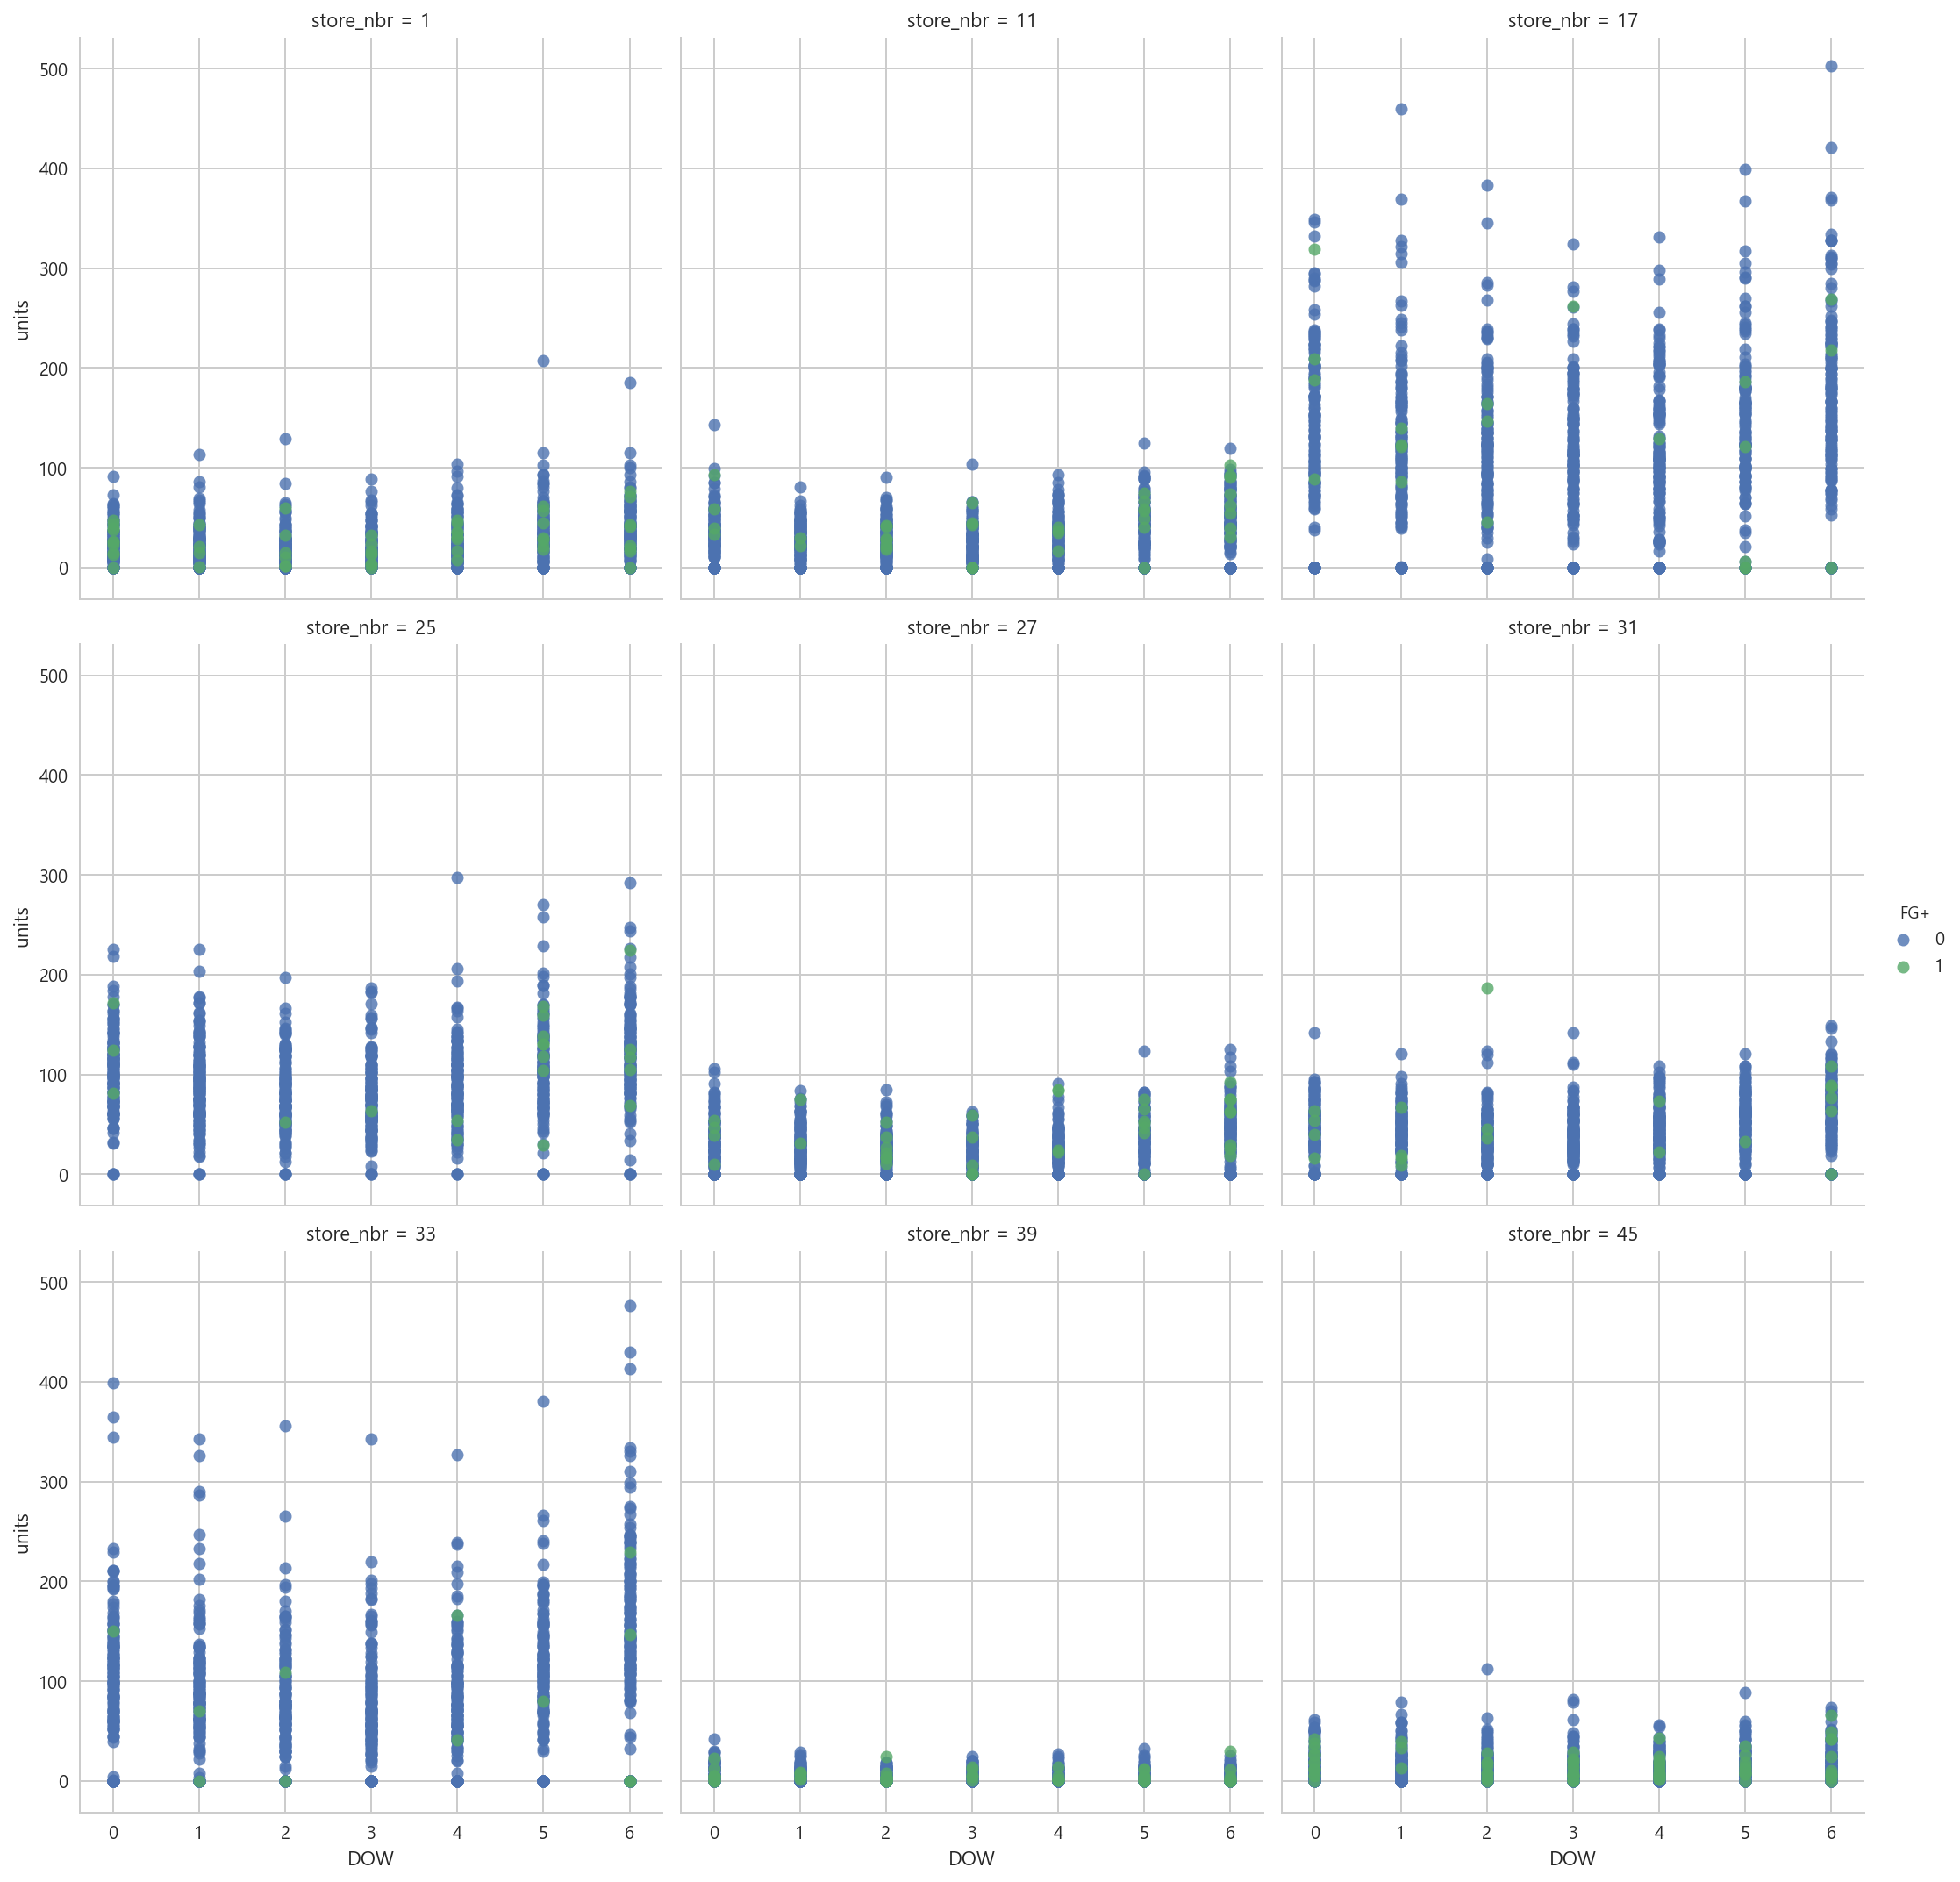

In [40]:
tdf = df[(df["store_nbr"])&(df["item_nbr"]==9)]
sns.lmplot(data=tdf, x="DOW", y="units", col='store_nbr', col_wrap=3, hue="FG+", fit_reg=False, order=1)
plt.show()

In [ ]:
# g = sns.PairGrid(df, diag_sharey=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_upper(plt.scatter)
# g.map_diag(sns.kdeplot, lw=3)

# 중간과정 - 특성파악 및 특성치 뽑아내기

In [ ]:
# 스토어 번호로 할당된 스토어당 아이템 넘버 확인 및 갯수확인
# 특성형 데이터프레임 뽑아내기
ls = list(set(bright_bf["item_nbr"]))
ls.sort()
store_item = df.pivot_table("units","item_nbr","store_nbr", aggfunc=np.count_nonzero)
# avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
# store_item.astype(int)
cnt = 0
df_char = pd.DataFrame(columns=["item_nbr","store_nbr","sell_days"])
for i in ls:
    print('item_nbr : ' ,i)
    ls2 = store_item.loc[i]
    for j,k in enumerate(ls2):
        if k>0:
            df_char.loc[len(df_char)] = {'item_nbr':i, 'store_nbr':j+1, 'sell_days':k}
            print(" └--store_nbr : ",j+1," / sd : ",k)
    cnt += len(store_item.loc[i].dropna())
    
print("총 해야할갯수(최대) : ", cnt)
df_char

In [ ]:
# 한번도 안팔린 달
pivot_df = df.groupby(["item_nbr", "month"]).mean().reset_index().pivot(index =  "month", columns = "item_nbr", values = "units")
pivot_df.style.apply(lambda x: ["background: #F78181" if abs(v) == 0 else "" for v in x], axis = 1)

In [ ]:
pivot_df.style.apply(lambda x: [("background: #F78181" if abs(v) == 0 else "background: #F7C1C1") if abs(v)<1 else "" for v in x], axis = 1)

In [19]:
# 2014.02 이후 안팔림 17, 18, 19, 20, 21, 29, 52

# 2014.04 까지 안팔렸음 22

#2013.10이후 안팔림 24, 33, 69, 86

#2013.08까지 안팔렸음 38 , 47
#2013.08이후 안팔림 42
#2013.09까지 안팔렸음 64
#2013.05이후 안팔림 85, 88
#2013.03이후 안팔림 93
#2013.06이후 안팔림 48, 89
#2013.01이후 안팔림 46
#2013.02이후 안팔림 81
#2012.05까지 안팔렸음 54, 75
#2013.07이후 없음 84


# 기간제 아이템 앞뒤 자르기

def cutFH(df_ext,pivot_df,j): #함수에서 쓰는 함수입니다. 직접사용하지마세용~
    switch = 0
    for i in range(5,34): #기간월 앞부분 자르기(3개월 이상 연속)
        if (pivot_df.iloc[i-5,j-1] == 0) and (pivot_df.iloc[i-4,j-1] == 0) and (pivot_df.iloc[i-3,j-1] == 0) \
        and (pivot_df.iloc[i-2,j-1] == 0) and (pivot_df.iloc[i-1,j-1] == 0) and (pivot_df.iloc[i,j-1] == 0) and (switch==0):
            switch = 1
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i-5)//12))|(df_ext["month"]!=((i-5)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i-4)//12))|(df_ext["month"]!=((i-4)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i-3)//12))|(df_ext["month"]!=((i-3)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i-2)//12))|(df_ext["month"]!=((i-2)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i-1)//12))|(df_ext["month"]!=((i-1)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + i//12))|(df_ext["month"]!=(i%12+1))]
        elif (pivot_df.iloc[i,j-1] == 0) and (switch==1):
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + i//12))|(df_ext["month"]!=(i%12+1))]
        else : 
            break
    print(j,".", end="")
    return df_ext


def cutBH(df_ext,pivot_df,j): #함수에서 쓰는 함수입니다. 직접사용하지마세용~
    switch = 0
    for i in range(28,-1,-1): #기간월 뒤부터 자르기(3개월 이상 연속)
        if (pivot_df.iloc[i+5,j-1] == 0) and (pivot_df.iloc[i+4,j-1] == 0) and (pivot_df.iloc[i+3,j-1] == 0)\
        and (pivot_df.iloc[i+2,j-1] == 0) and (pivot_df.iloc[i+1,j-1] == 0) and (pivot_df.iloc[i,j-1] == 0) and (switch==0):
            switch = 1
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i+5)//12))|(df_ext["month"]!=((i+5)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i+4)//12))|(df_ext["month"]!=((i+4)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i+3)//12))|(df_ext["month"]!=((i+3)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i+2)//12))|(df_ext["month"]!=((i+2)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + (i+1)//12))|(df_ext["month"]!=((i+1)%12+1))]
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + i//12))|(df_ext["month"]!=(i%12+1))]
        elif (pivot_df.iloc[i,j-1] == 0) and (switch==1):
            df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + i//12))|(df_ext["month"]!=(i%12+1))]
        else : 
            break
    print(j,".", end="")
    return df_ext


# 기간제 아이템 앞뒤 자르기
def cutForeBehindPeriod(df):
    
    pivot_df = df.groupby(["item_nbr", "year","month"]).mean().reset_index().pivot_table(index =  ["year","month"], columns = "item_nbr", values = "units")

    df_ext = df
    print("판매안하던 이전시점 삭제하기 : ")
    for j in range(1,112): #아이템넘버
        df_ext = cutFH(df_ext,pivot_df,j)
            
    print("특정일 이후 안파는 데이터 삭제하기 : ")
    for j in range(1,112): #아이템넘버
        df_ext = cutBH(df_ext,pivot_df,j)

    return df_ext


def cutForePeriod(df):
    
    pivot_df = df.groupby(["item_nbr", "year","month"]).mean().reset_index().pivot_table(index =  ["year","month"], columns = "item_nbr", values = "units")

    df_ext = df
    print("판매안하던 이전시점 삭제하기 : ")
    for j in range(1,112): #아이템넘버
        df_ext = cutFH(df_ext,pivot_df,j)   

    return df_ext


def cutBehindPeriod(df):
    
    pivot_df = df.groupby(["item_nbr", "year","month"]).mean().reset_index().pivot_table(index =  ["year","month"], columns = "item_nbr", values = "units")

    df_ext = df
    print("특정일 이후 안파는 데이터 삭제하기 : ")
    for j in range(1,112): #아이템넘버
        df_ext = cutBH(df_ext,pivot_df,j) 

    return df_ext
# 


# 예측값을 0으로 채워버리기(강제함수)
def fillZeroNullPeriod(Predf,df):
    pivot_df = df.groupby(["item_nbr", "year","month"]).mean().reset_index().pivot_table(index =  ["year","month"], columns = "item_nbr", values = "units")

    df_ext = df
    print("판매안하던 이전시점 예측하기(0으로) : ")
    for j in range(1,112): #아이템넘버
        for i in range(0,34): #기간월 앞부분 자르기
            if pivot_df.iloc[i,j-1] == 0:
                Predf.iloc[[(df_ext["item_nbr"]==j)&(df_ext["year"]==(2012 + i//12))&(df_ext["month"]==(i%12+1))]] = 0
            else : 
                break
        print(j,".", end="")    
    print("특정일 이후 안파는 시검 예측하기(0으로) : ")
    for j in range(1,112): #아이템넘버
        for i in range(33,-1,-1): #기간월 뒤부터 자르기
            if pivot_df.iloc[i,j-1] == 0:
                Predf.iloc[[(df_ext["item_nbr"]==j)&(df_ext["year"]==(2012 + i//12))&(df_ext["month"]==(i%12+1))]] = 0
            else : 
                break
        print(j,".", end="") 

    return Predf

# predict_alpha = cutForeBehindPeriod(predictions,X_test)
# pivot_df = df.groupby(["item_nbr", "year","month"]).mean().reset_index().pivot_table(index =  ["year","month"], columns = "item_nbr", values = "units")
# pivot_df

In [ ]:
df_a = cutForeBehindPeriod(df)
df_a

In [42]:
pivot_dfa = df_a.groupby(["item_nbr", "year","month"]).mean().reset_index().pivot_table(index =  ["year","month"], columns = "item_nbr", values = "units")
pivot_dfa.style.apply(lambda x: ["background: #F78181" if abs(v) == 0 else "" for v in x], axis = 1)

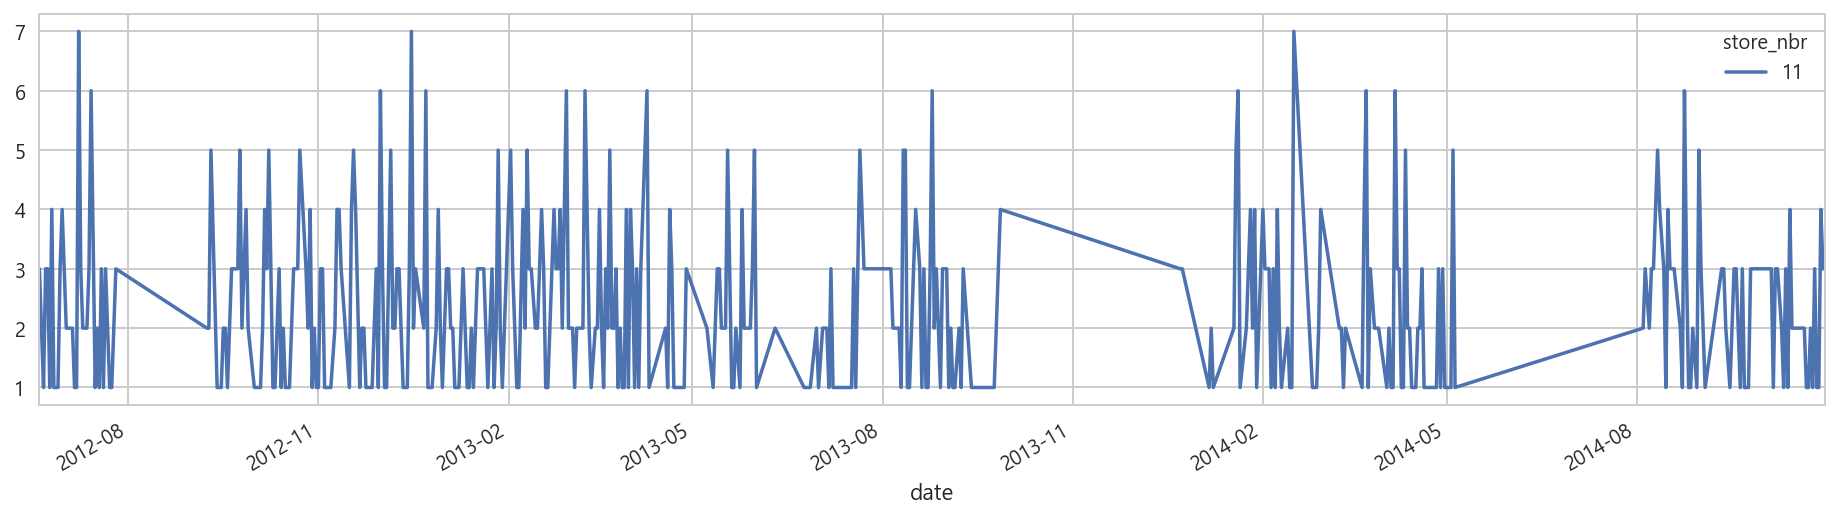

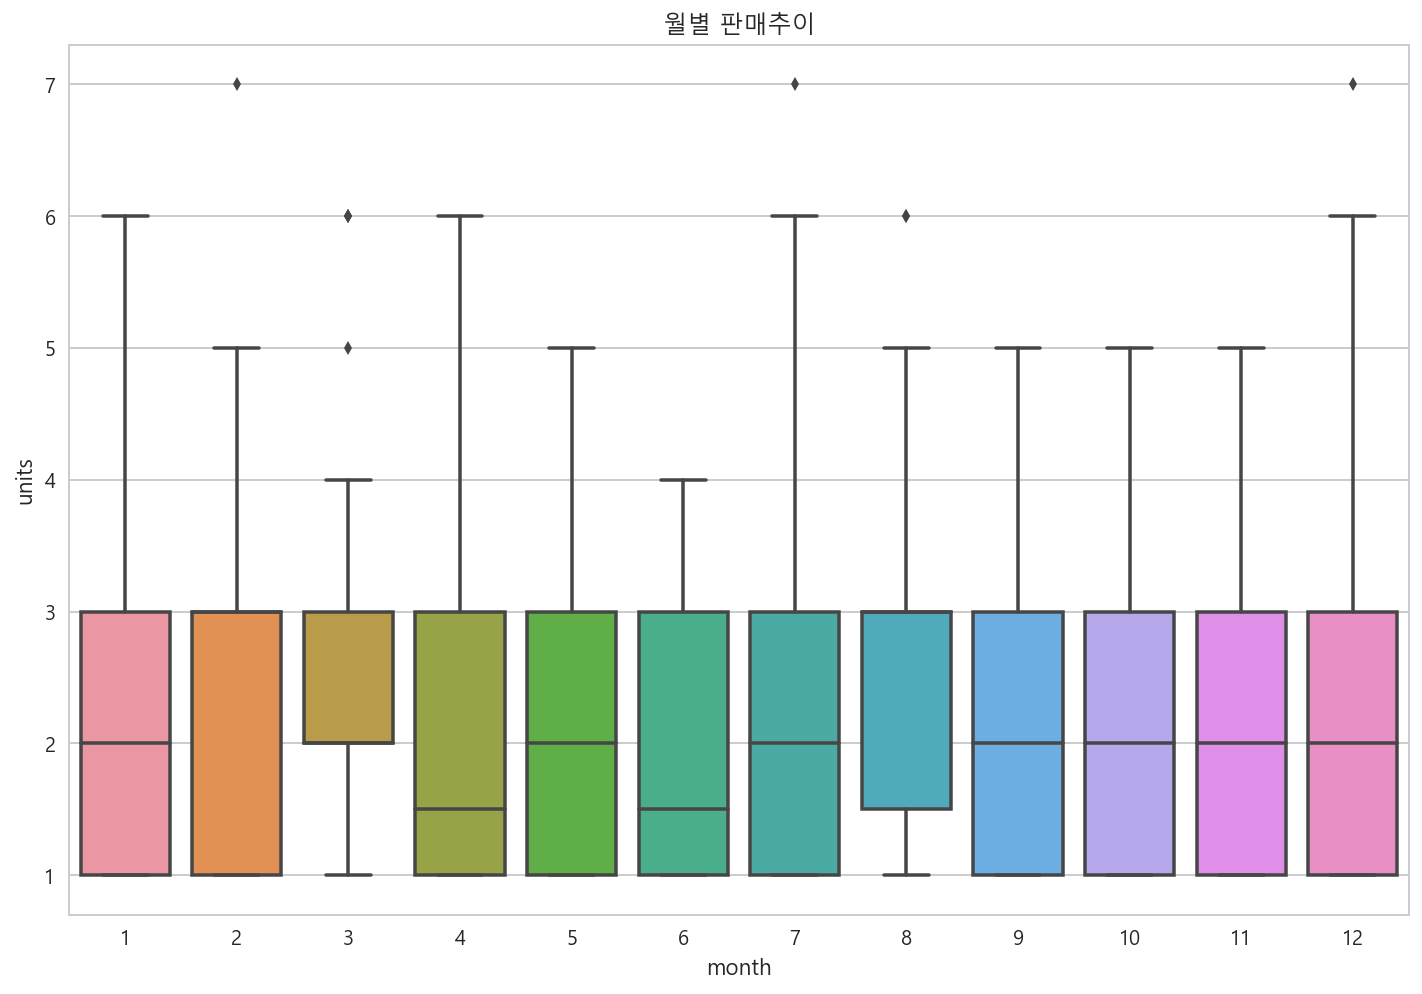

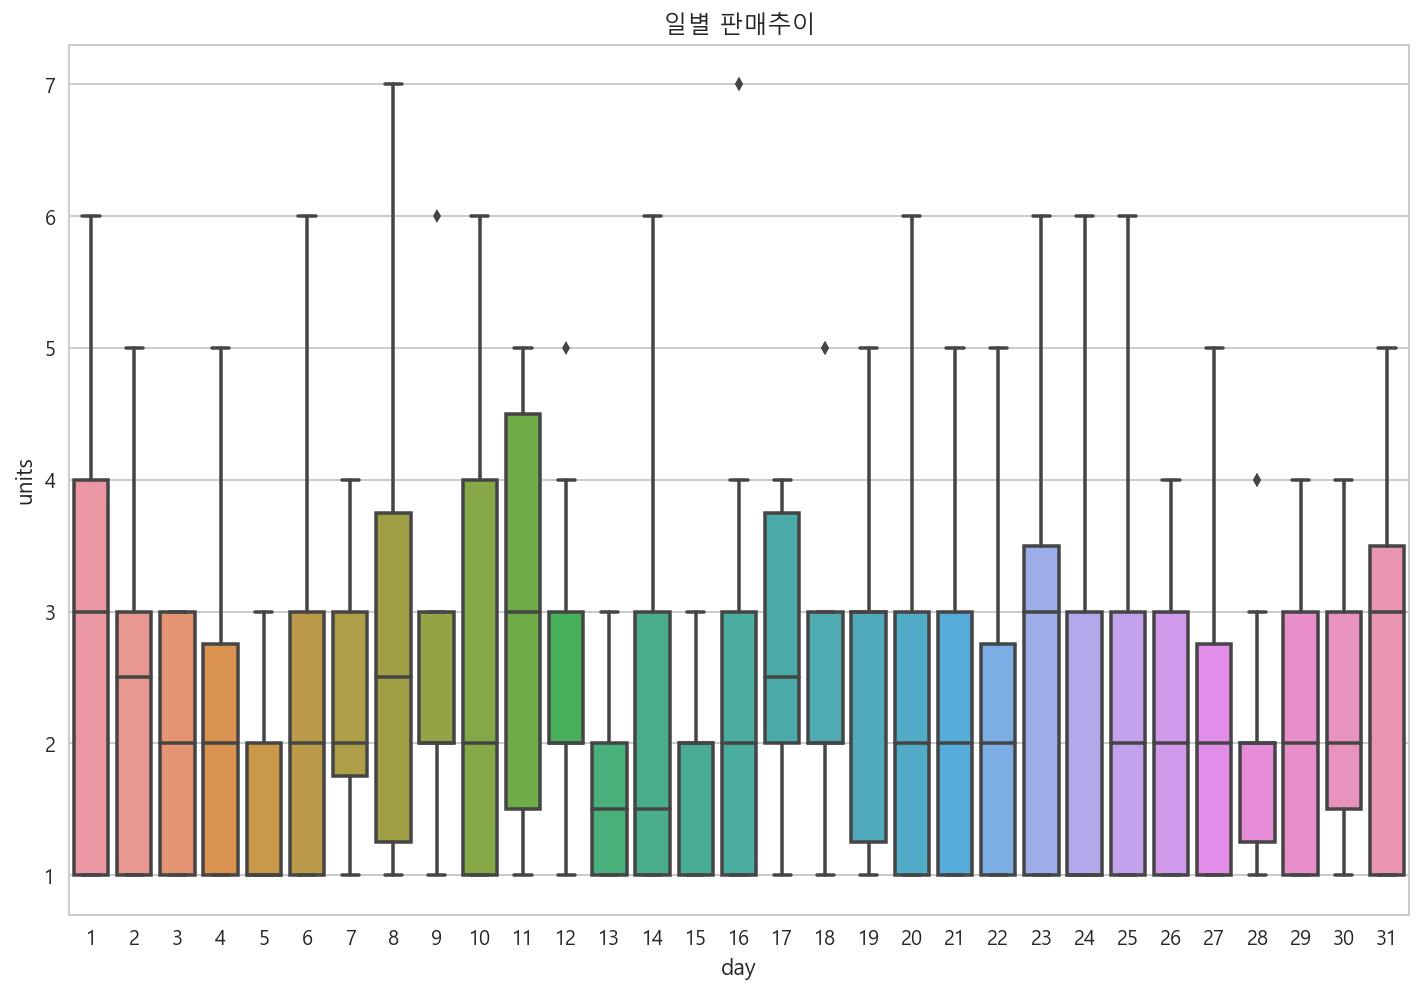

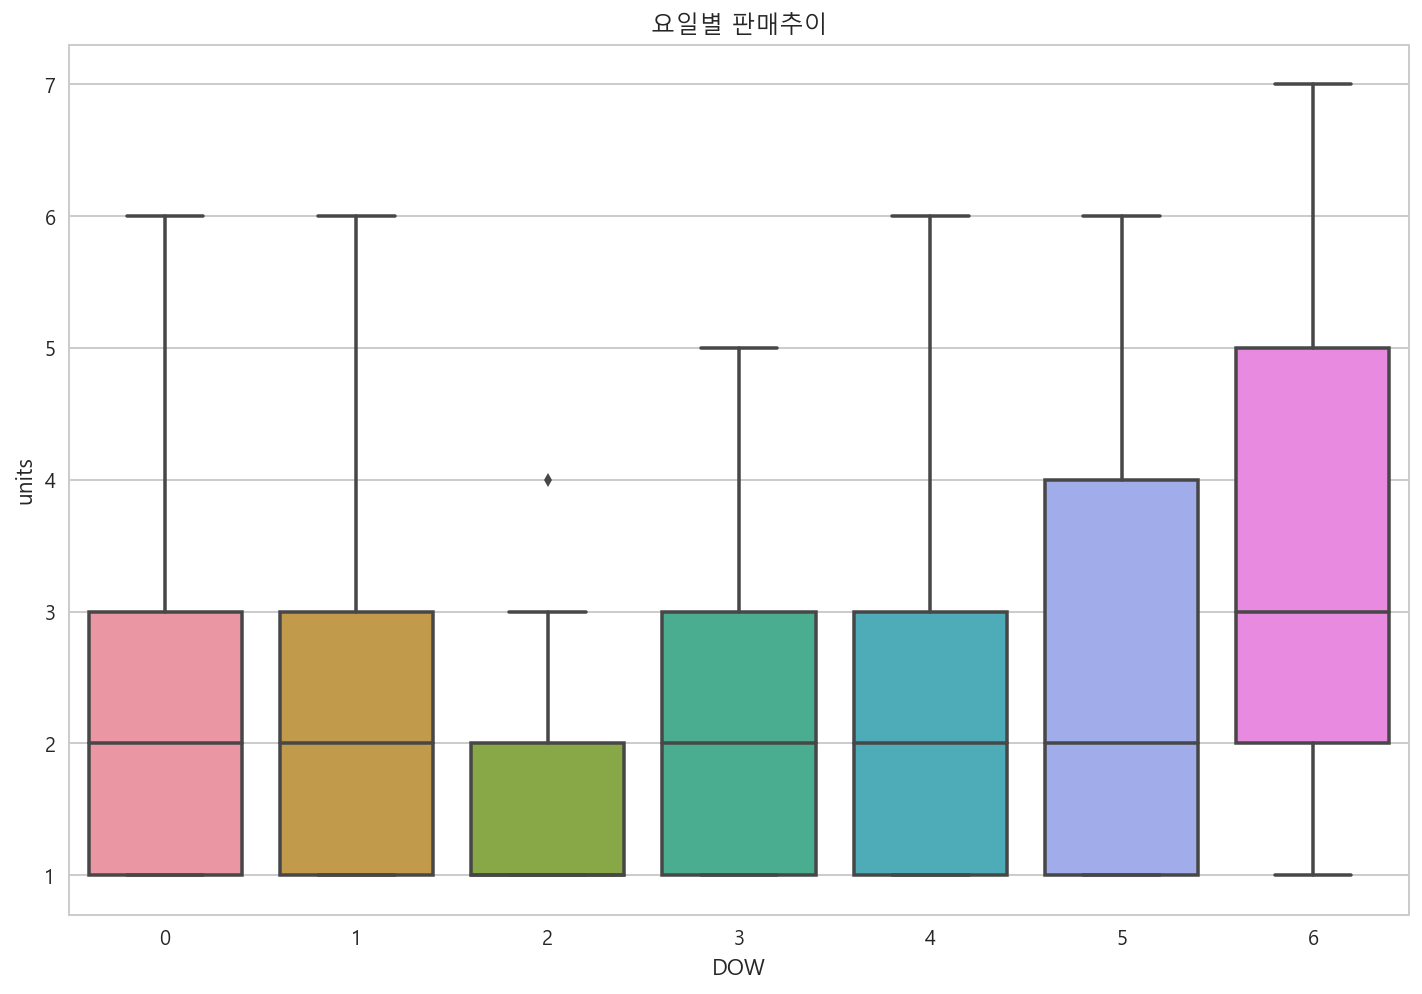

In [76]:
number = 87
item_n = df[(df["units"]>0)&(df["units"]<2000)&(df["item_nbr"]==number)&(df["store_nbr"]>=0)&(df["store_nbr"]<60)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")

item_n.pivot(index = "date", columns = "store_nbr", values = "units").plot(figsize=(16,4))
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(ax=ax, x="month", y="units", data=item_n).set_title("월별 판매추이")
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(ax=ax, x="day", y="units", data=item_n).set_title("일별 판매추이")
fig, ax1 = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(ax=ax1, x="DOW", y="units", data=item_n).set_title("요일별 판매추이")

plt.show()

# 1. 스토어별 비교 플롯뿌리기

In [ ]:
# 배정된 스토어 = {9, 14, 17, 18, 23, 26, 30, 31, 34, 36, 45}
#       'TS', 'GR', 'RA', 'DZ', 'SN',
#        'SG', 'GS', 'PL', 'FG+', 'FG',
#        'BR', 'UP', 'HZ', 'FU', 'DU',
#        'SQ', 'FZ', 'MI', 'PR', 'BC',
#        'BL', 'VC',
#        'year', 'month', 'day', 'DOW',
#        'SS', 'quarter', 'weekend', 'weekend2',
#        'units_mean'
Hli=["FG","FG+","RA","SN","TS"]
Vli=[9,14,17,18,23]

HVXY_multi_boxplot(df,Vcol="store_nbr",Xcol="item_nbr",Ycol="units",cutover=2500,Vlist=Vli, Hlist=Hli, plotsize=5)


# 2. 아이템별 비교 플롯뿌리기

HVXY running...
[451, 452, 453, 454, 455]
[456, 457, 458, 459, 4510]
[4511, 4512, 4513, 4514, 4515]
[4516, 4517, 4518, 4519, 4520]
plotting screen...

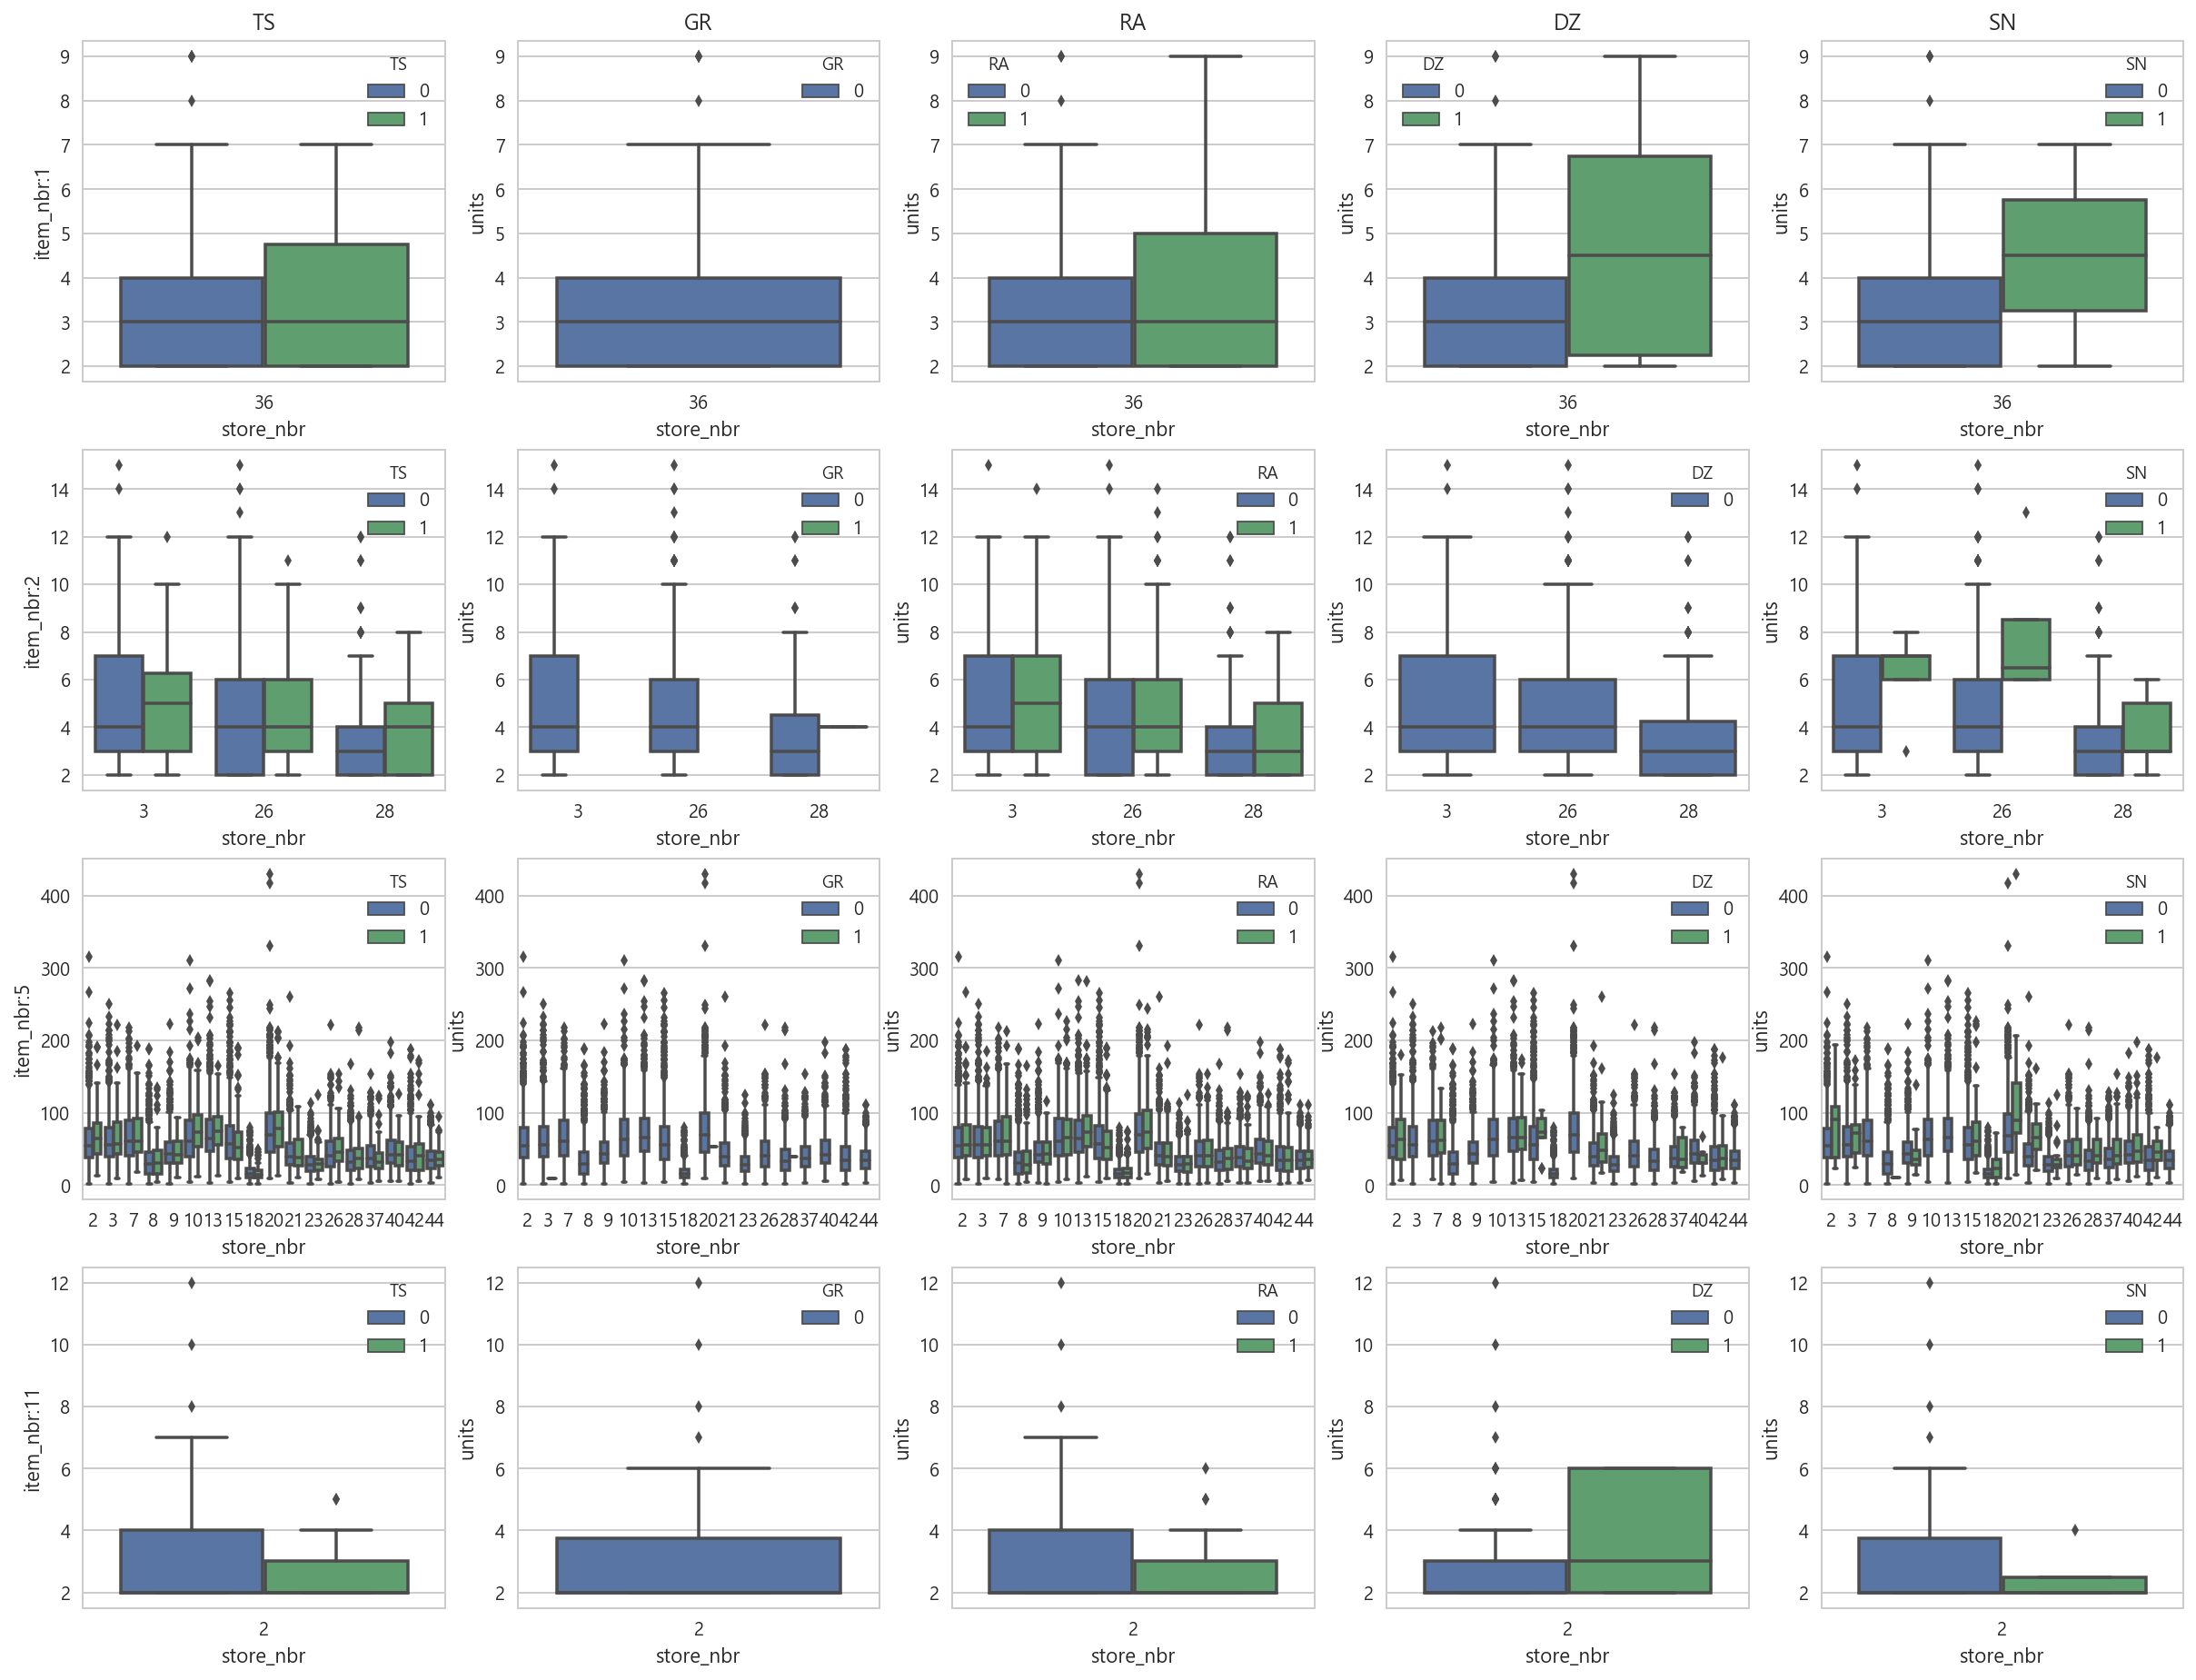

Complete!
HVXY running...
[451, 452, 453, 454, 455]
[456, 457, 458, 459, 4510]
[4511, 4512, 4513, 4514, 4515]
[4516, 4517, 4518, 4519, 4520]
plotting screen...

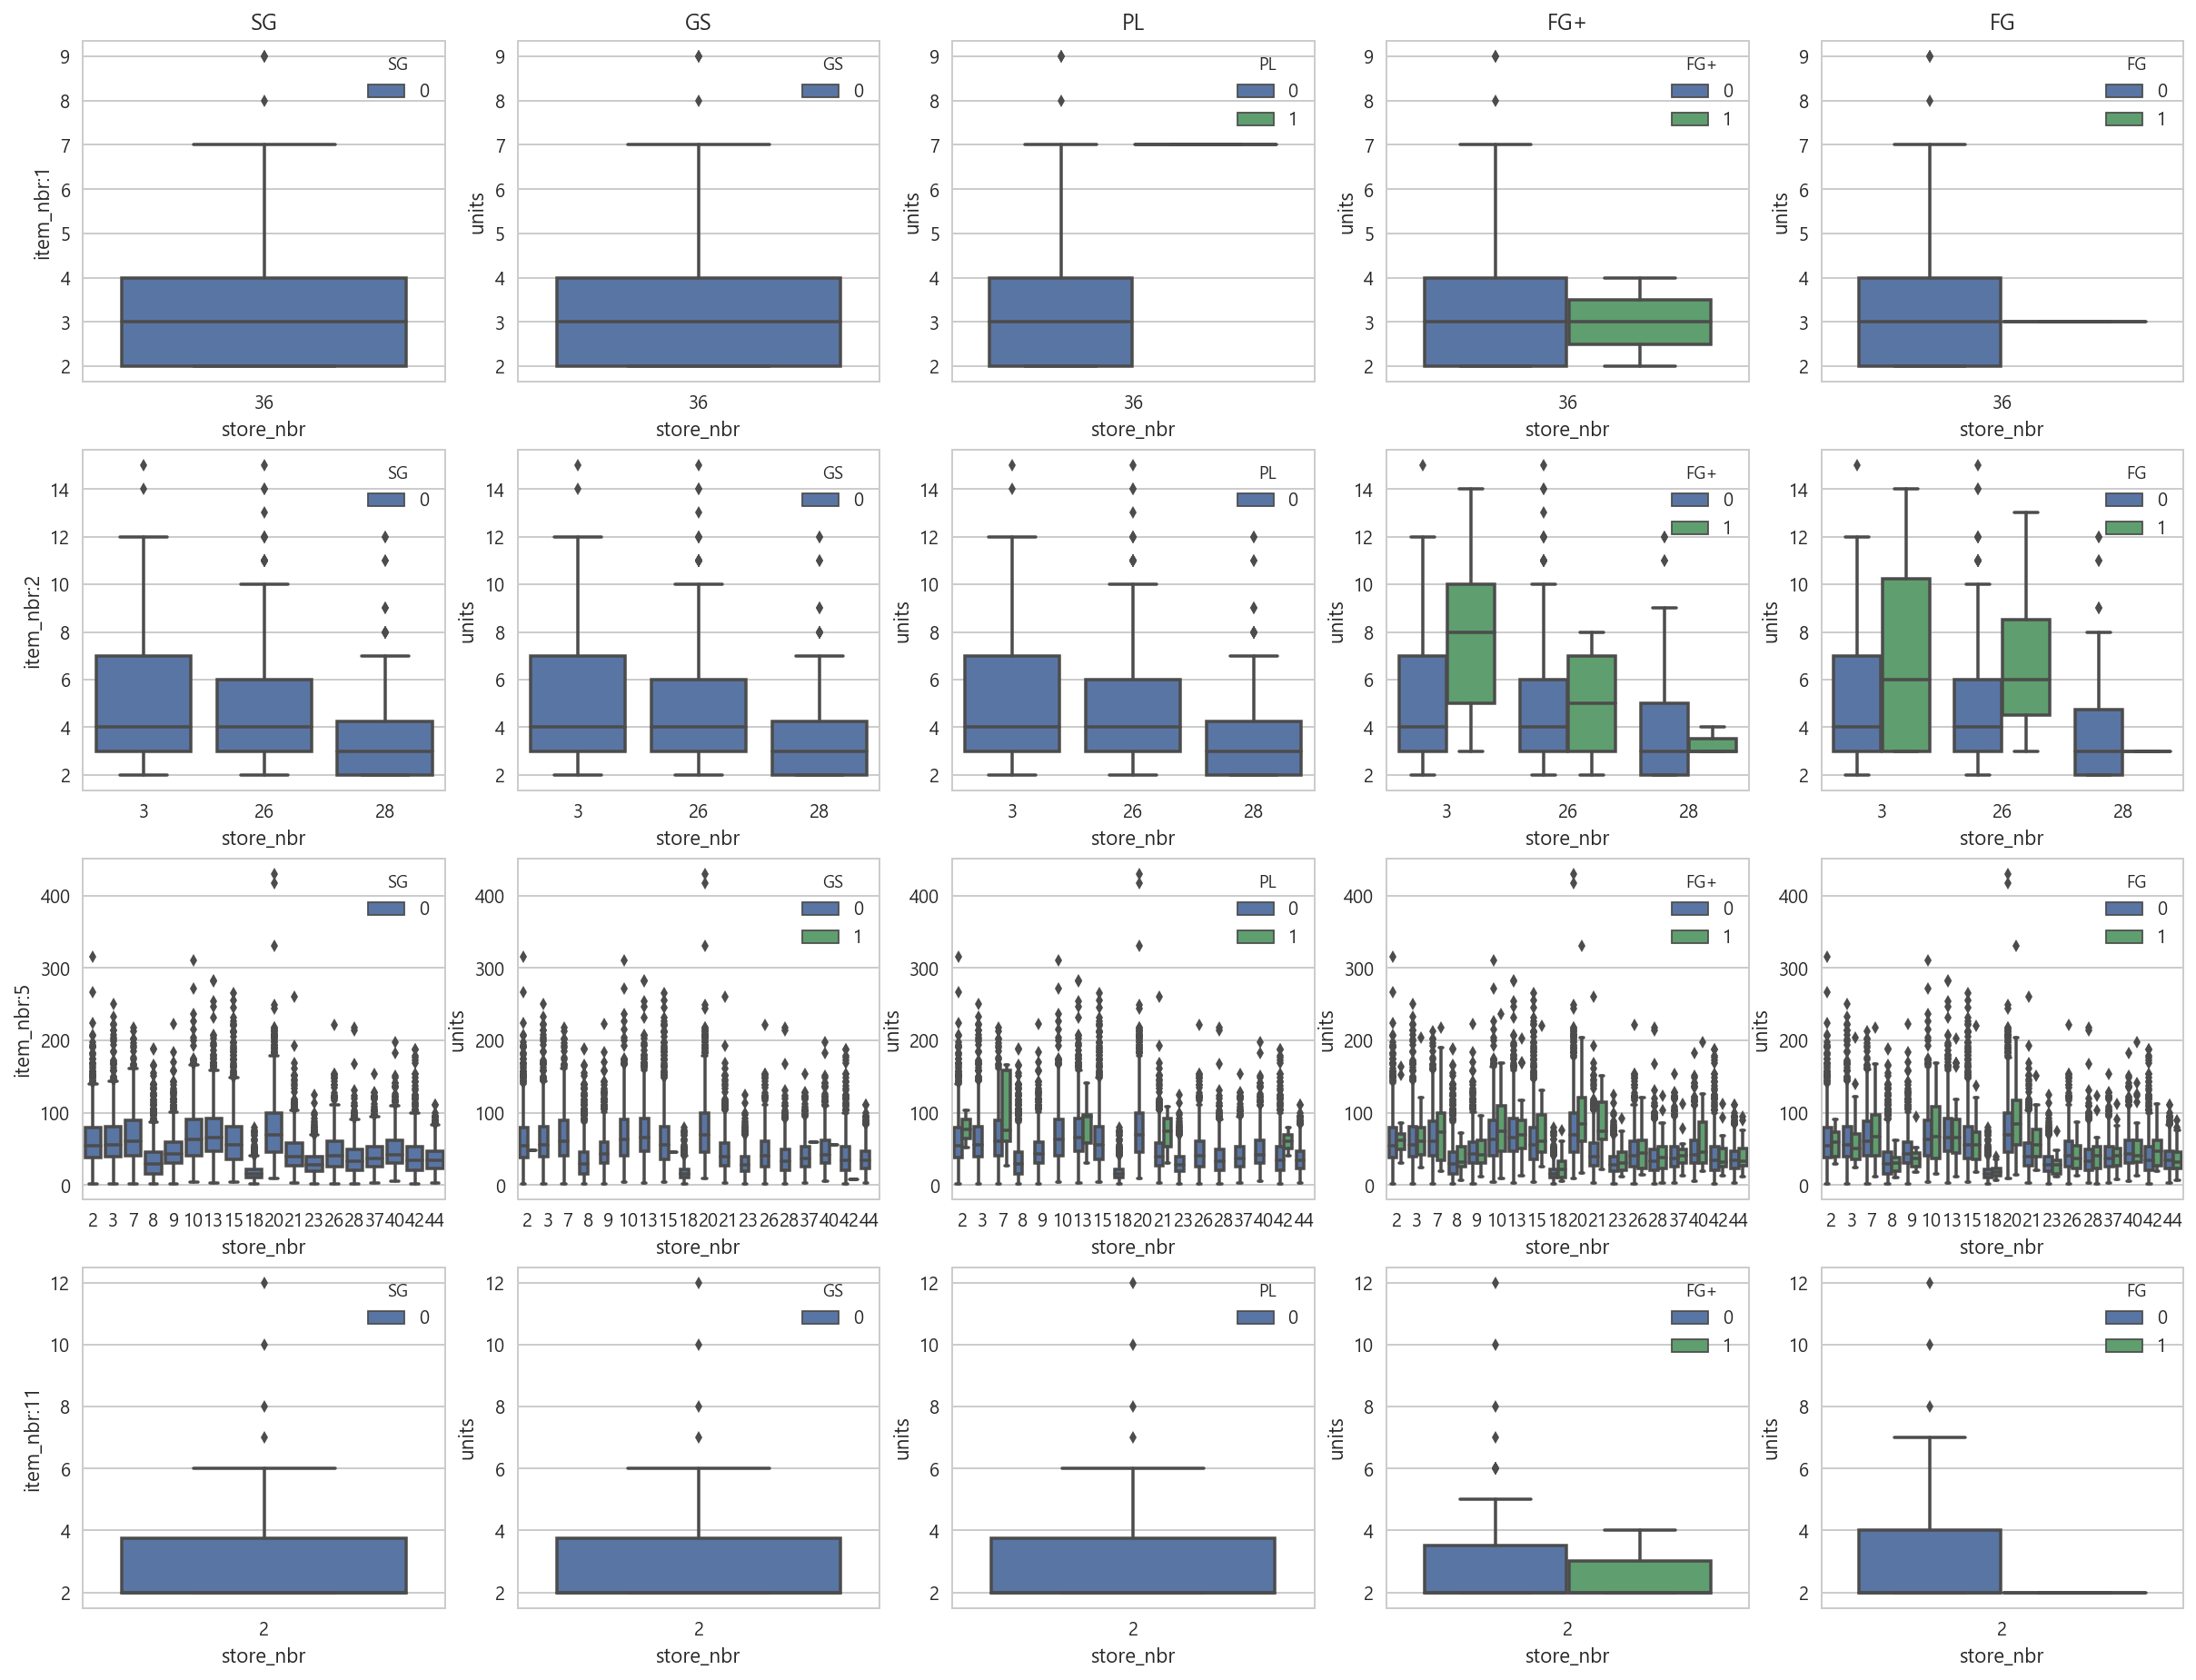

Complete!
HVXY running...
[451, 452, 453, 454, 455]
[456, 457, 458, 459, 4510]
[4511, 4512, 4513, 4514, 4515]
[4516, 4517, 4518, 4519, 4520]
plotting screen...

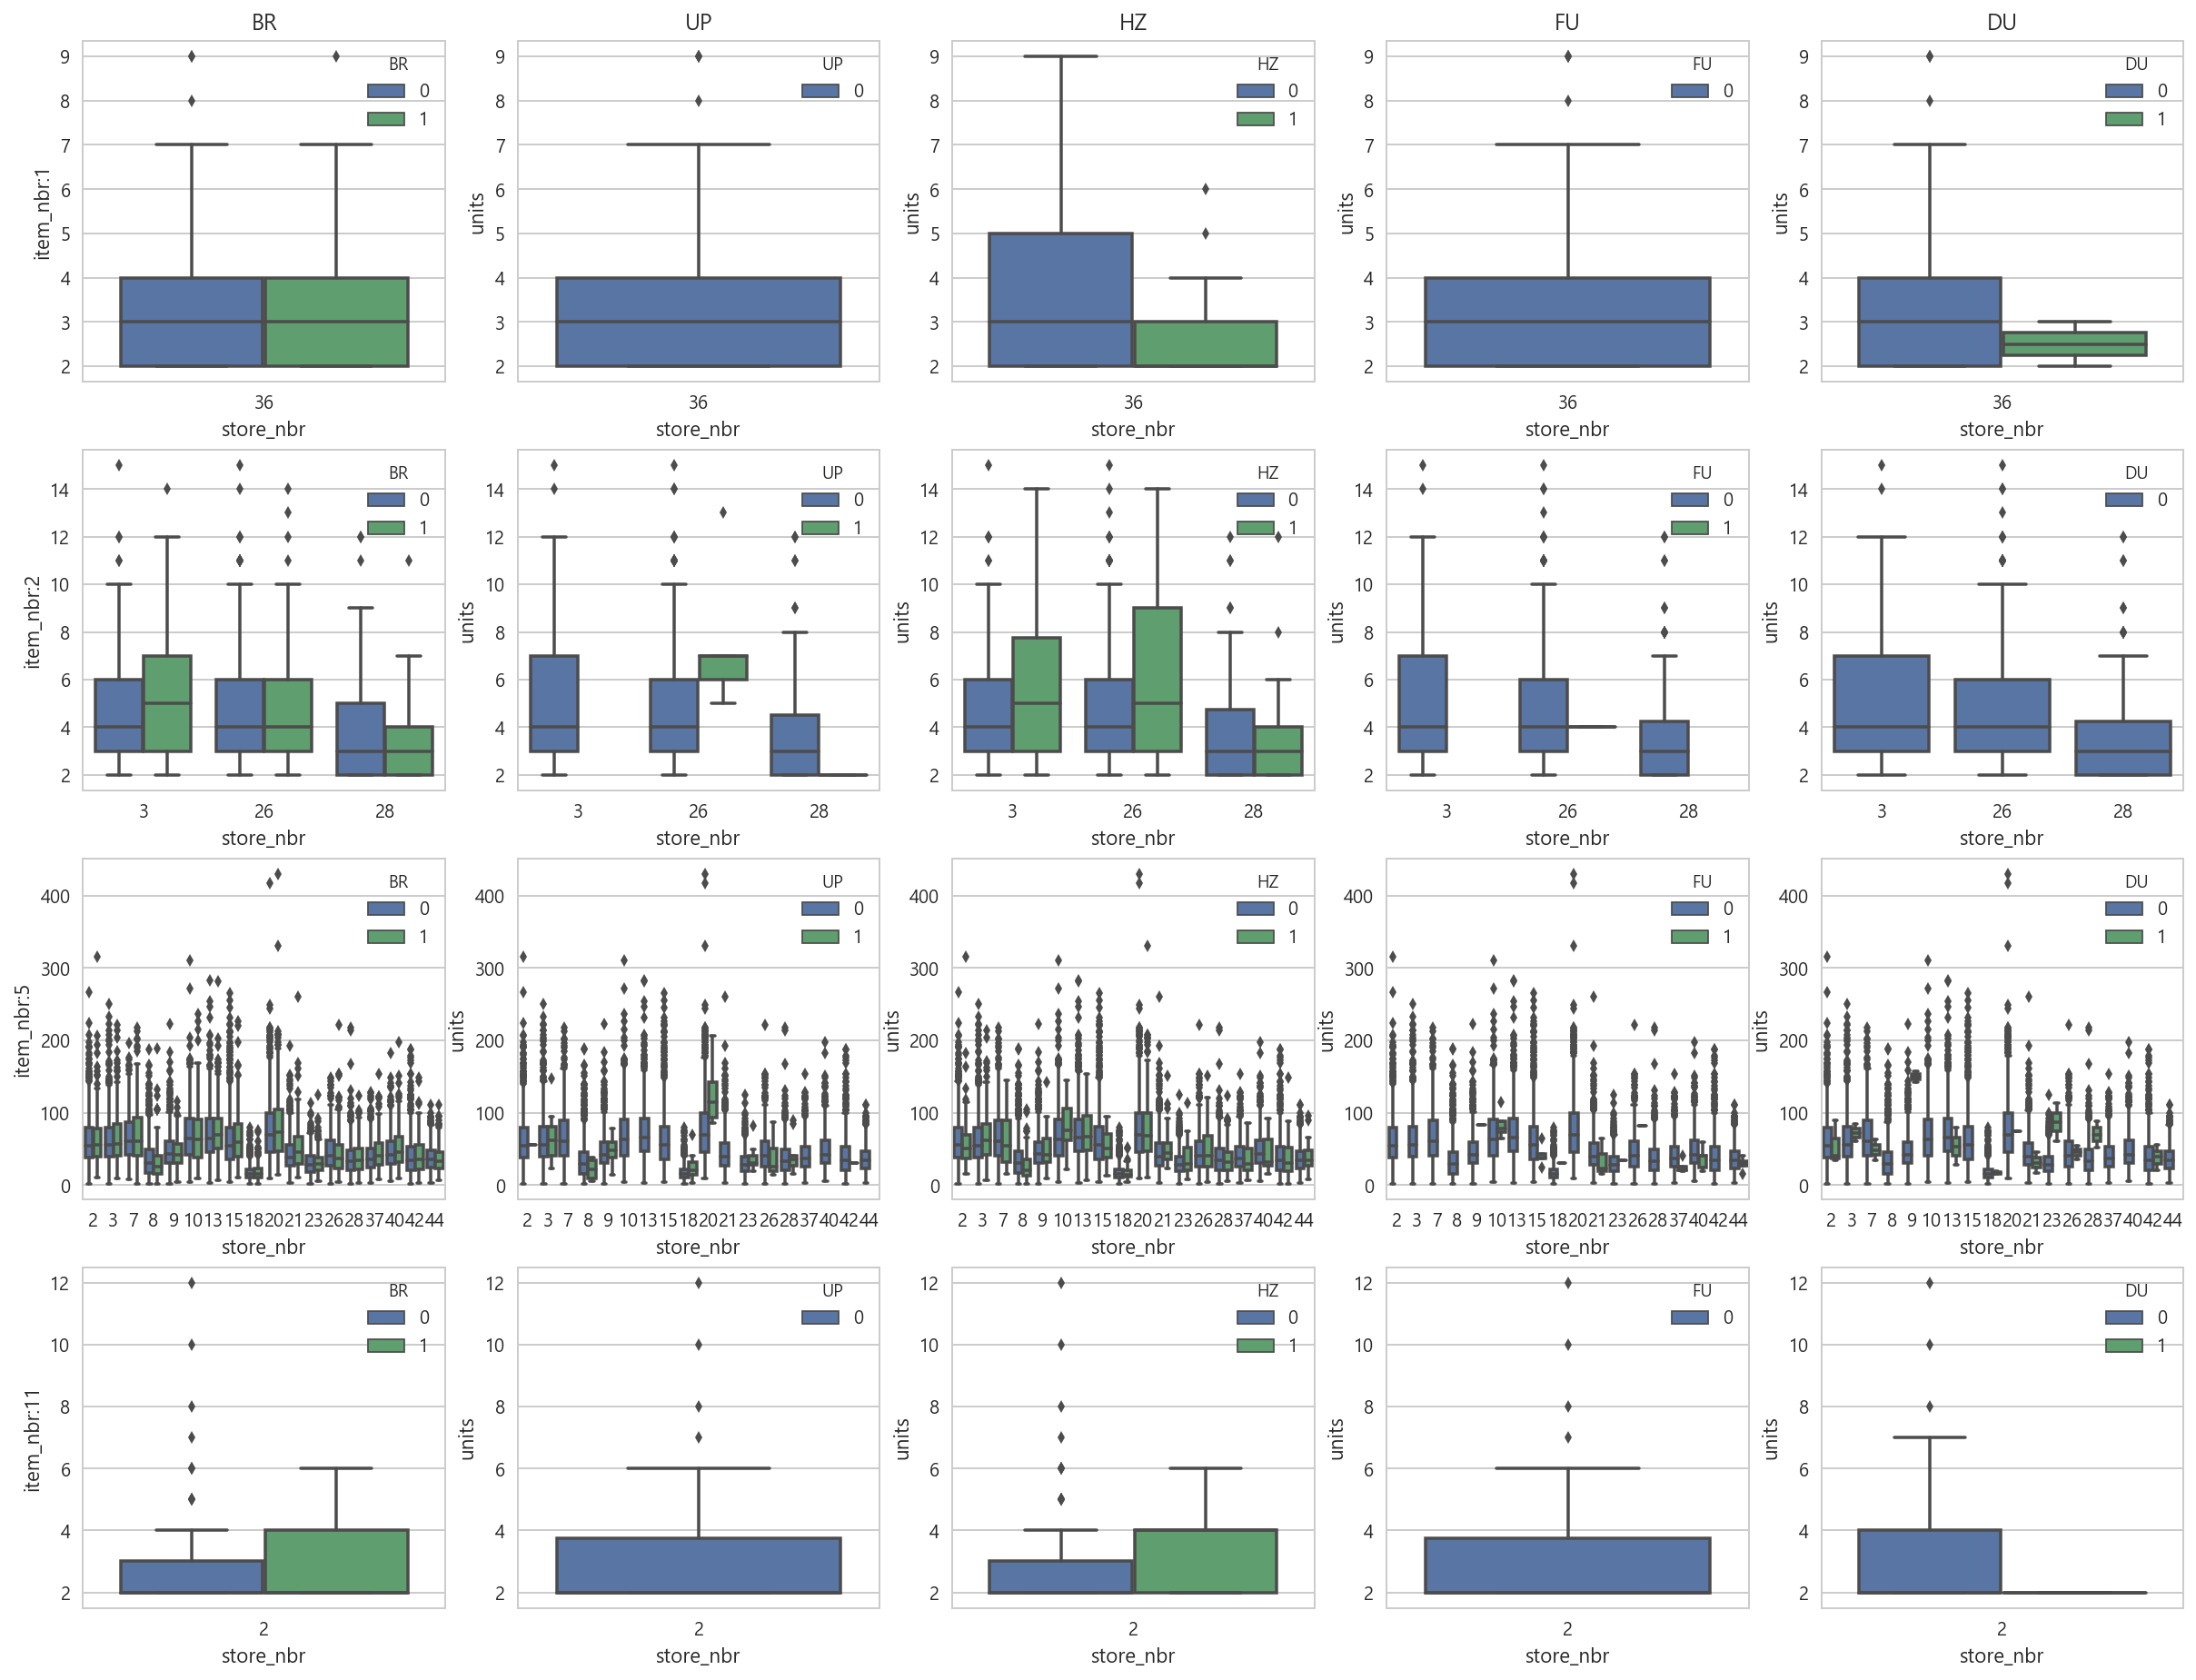

Complete!
HVXY running...
[451, 452, 453, 454, 455]
[456, 457, 458, 459, 4510]
[4511, 4512, 4513, 4514, 4515]
[4516, 4517, 4518, 4519, 4520]
plotting screen...

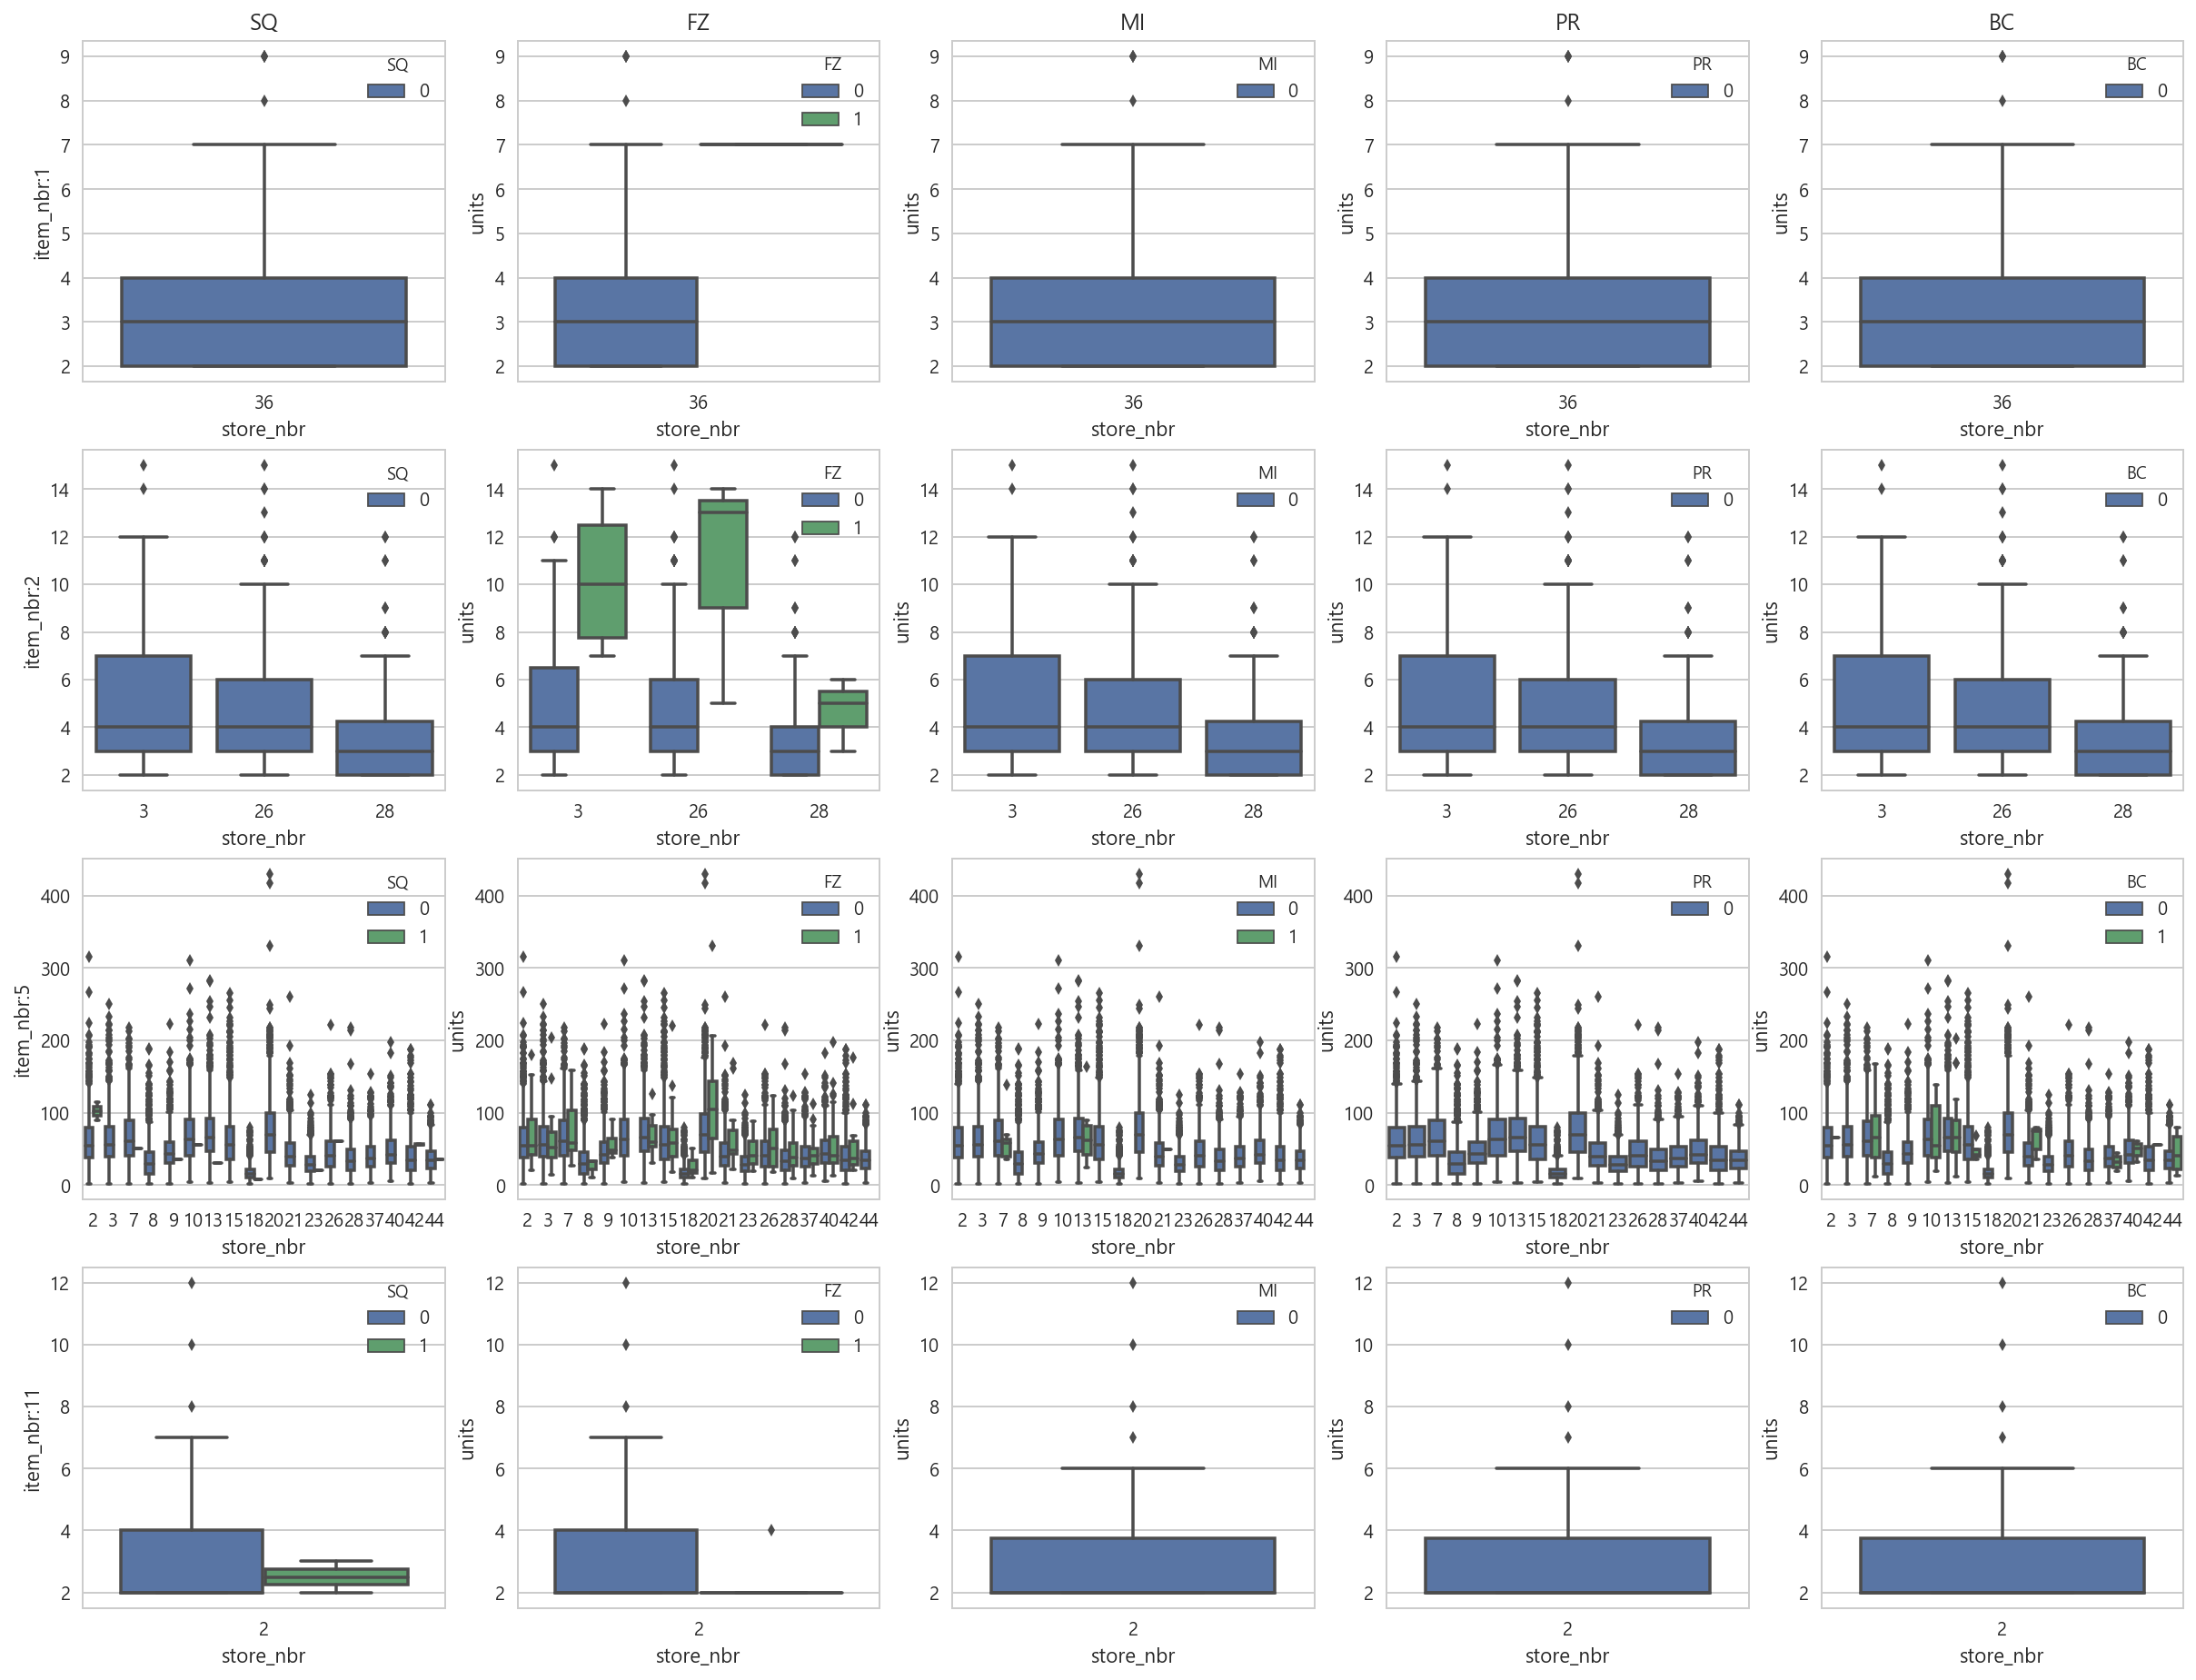

Complete!
HVXY running...
[451, 452, 453, 454, 455]
[456, 457, 458, 459, 4510]
[4511, 4512, 4513, 4514, 4515]
[4516, 4517, 4518, 4519, 4520]
plotting screen...

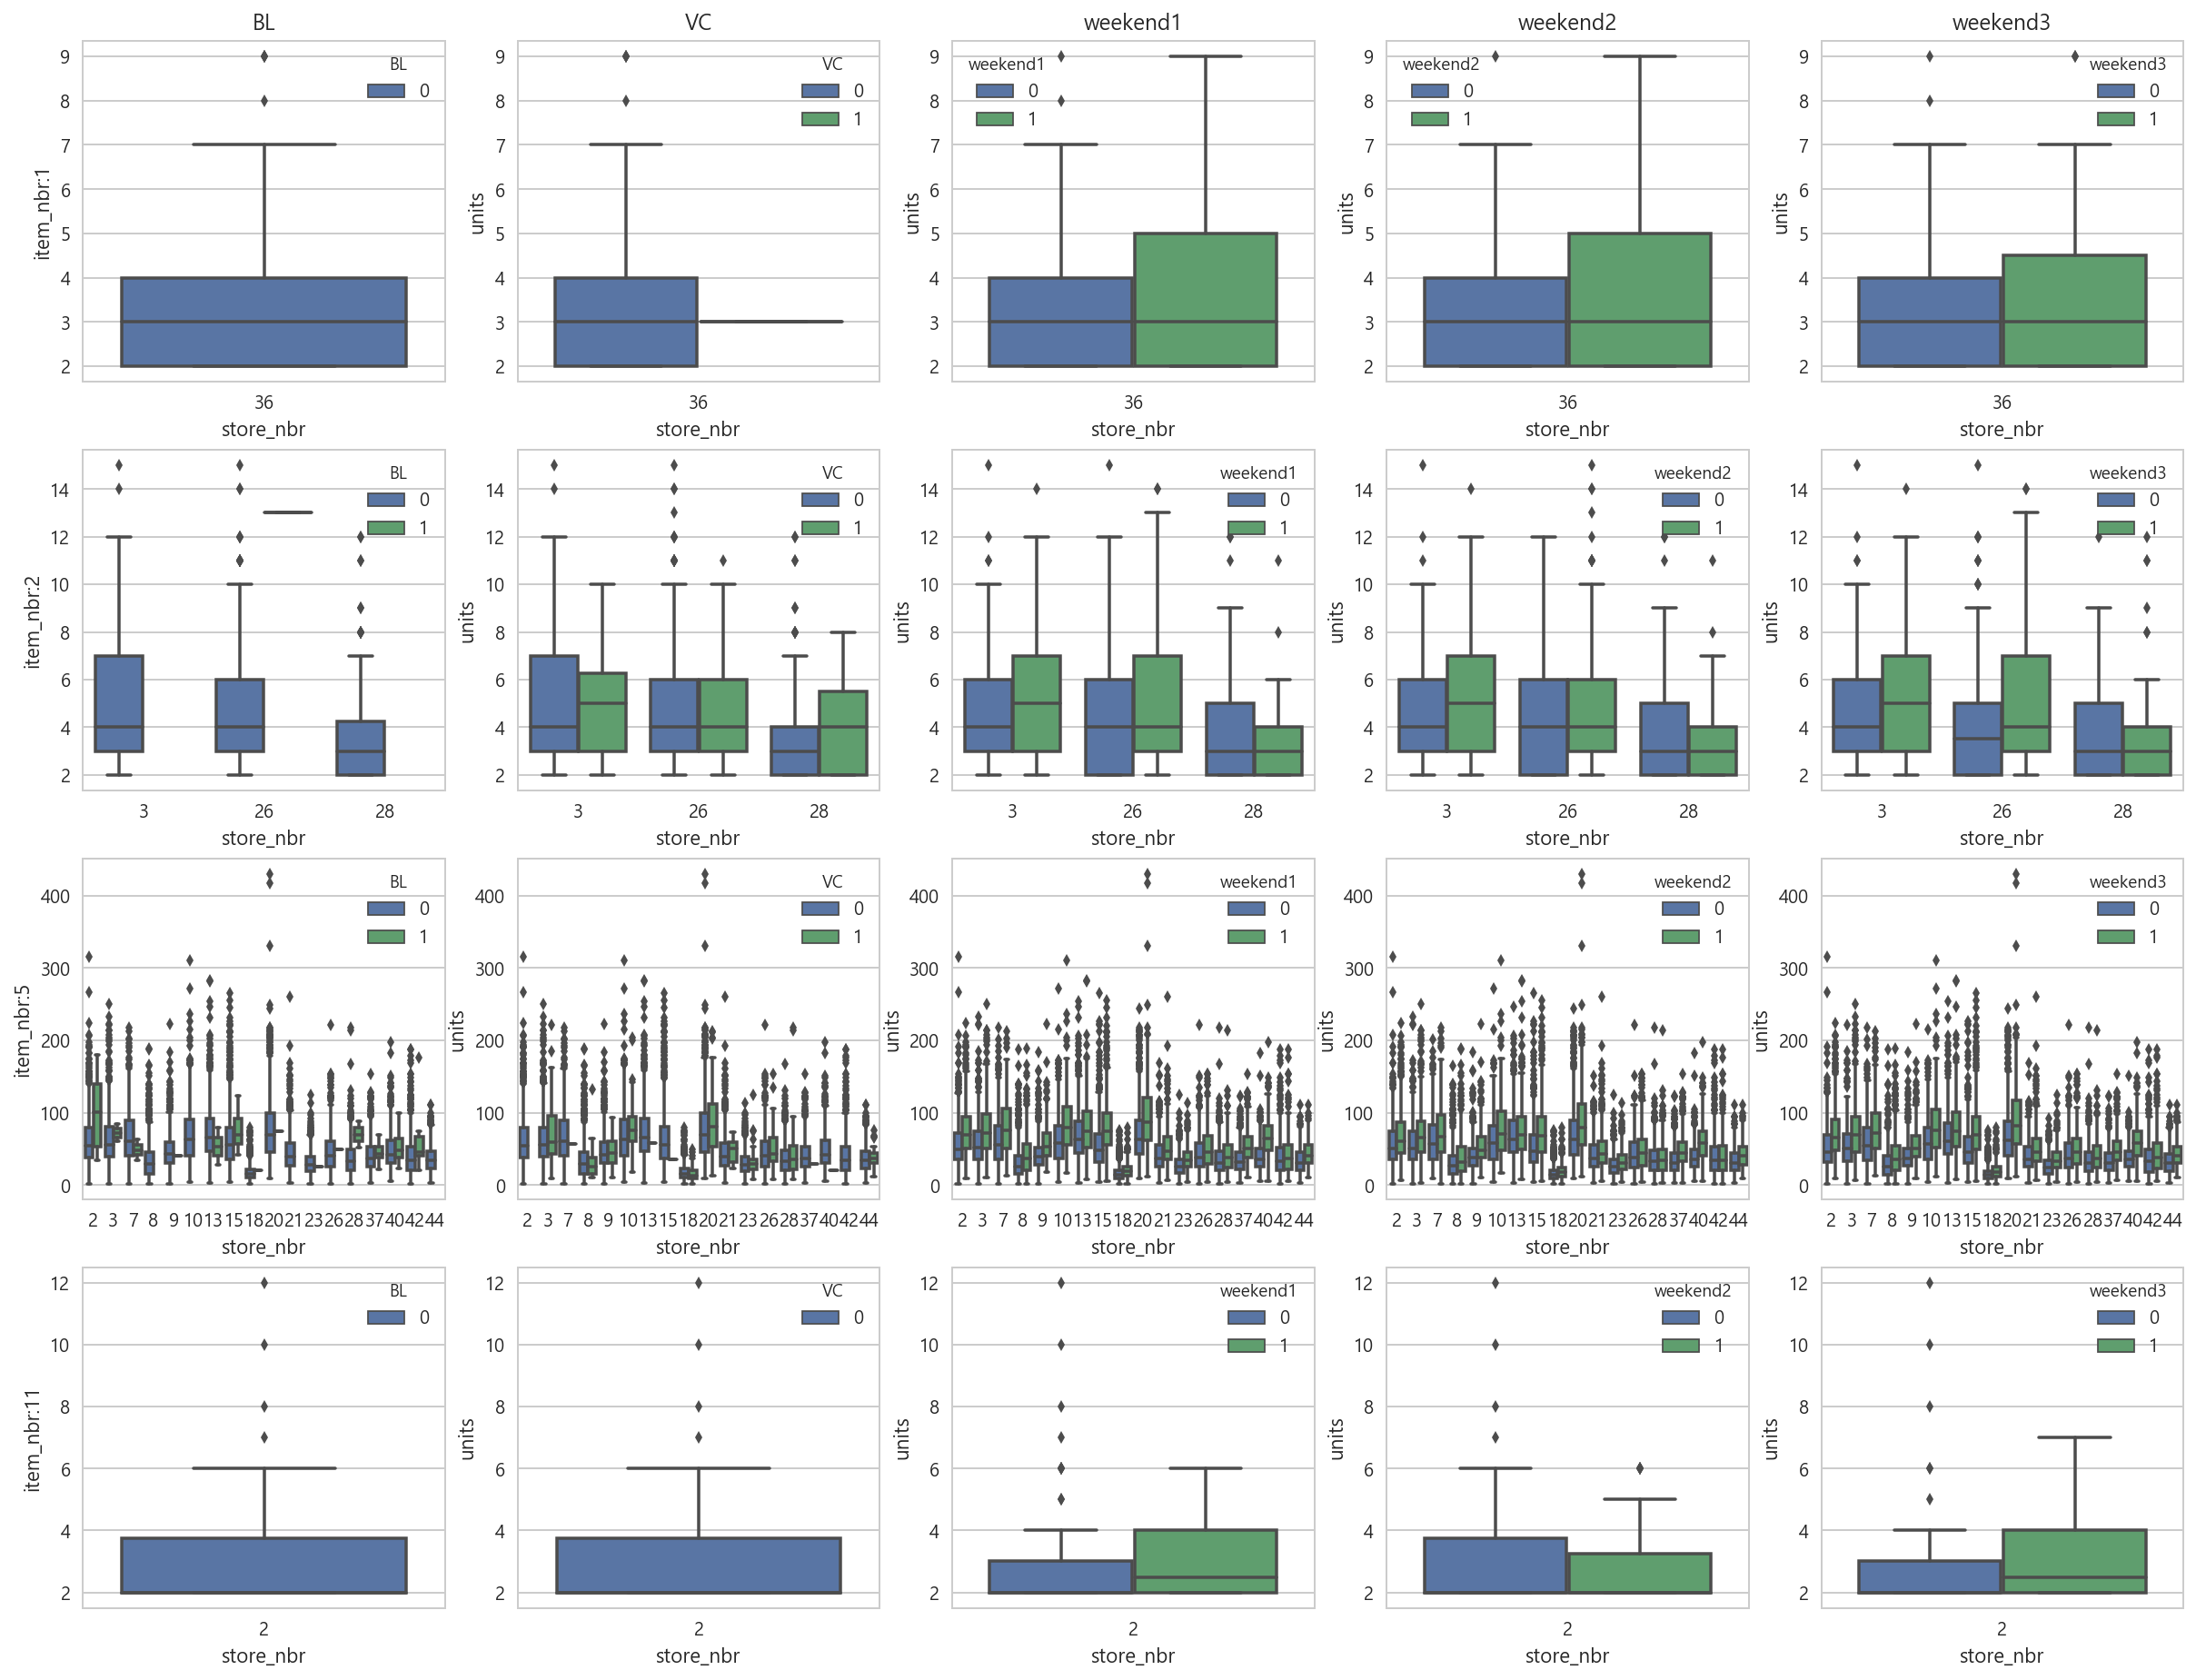

Complete!
HVXY running...
[421, 422]
[423, 424]
[425, 426]
[427, 428]
plotting screen...

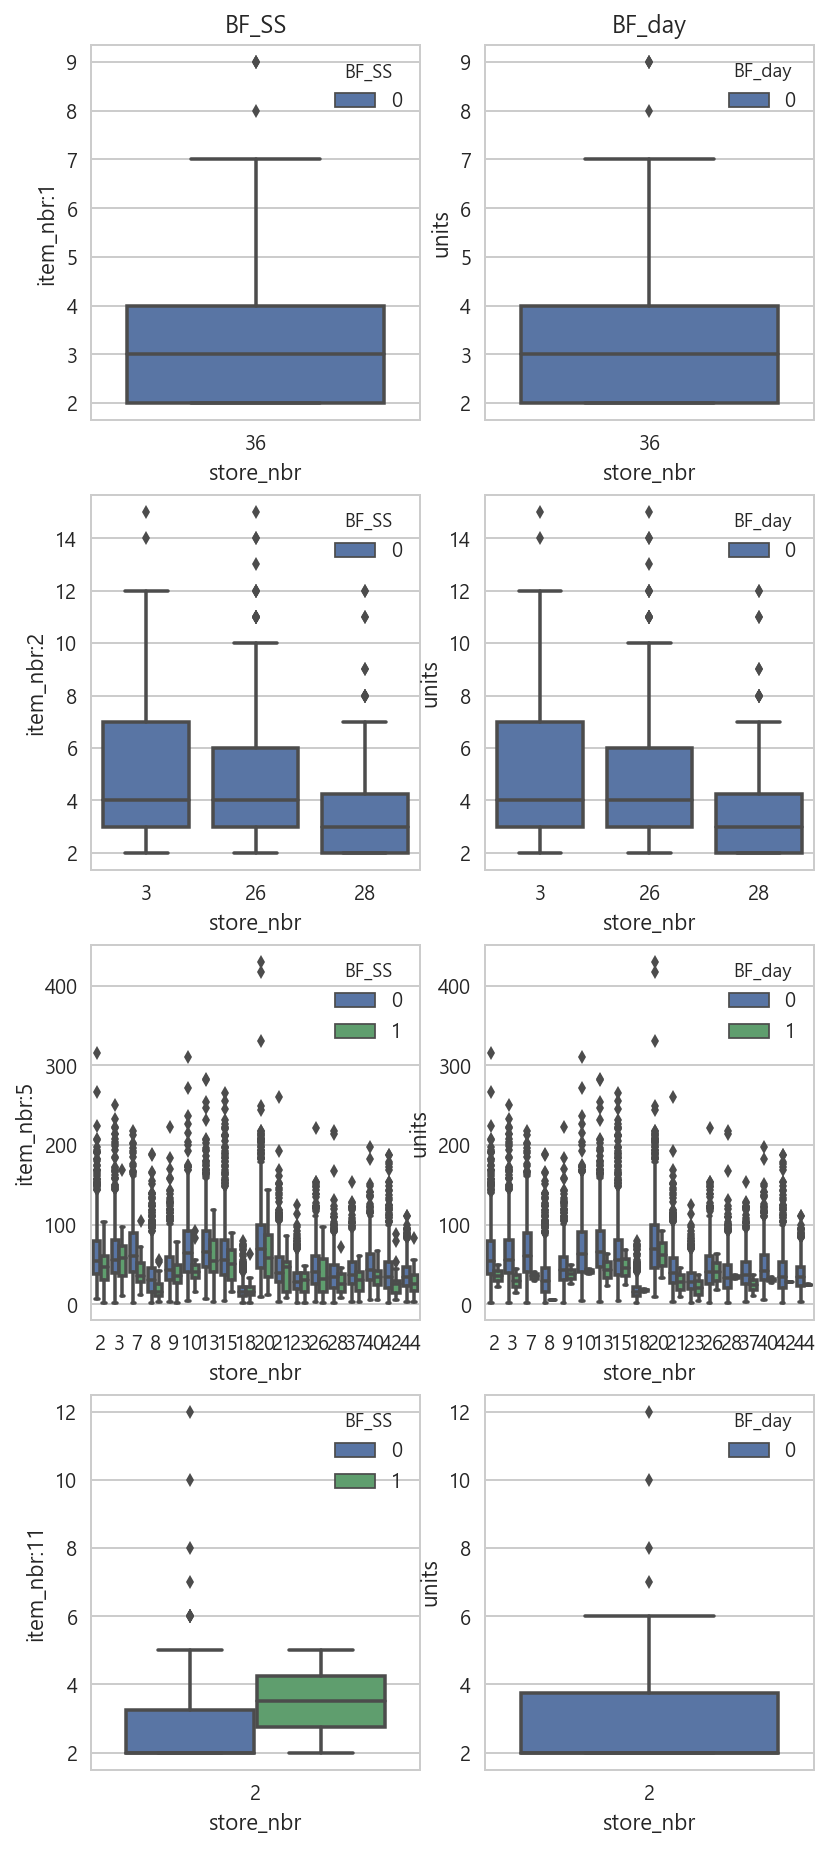

Complete!
units의 요일별 판매추이


NameError: name 'item_n' is not defined

In [41]:
# 10개이상의 스토어에서 판매되는 아이템들 = {5,9,45,93}
# 5개 이상의 스토어에서 판매되는 아이템들 = {15,16,37,44,50,68,86,105}
Itemls =[1,2,5,11]

Codels1 =['TS', 'GR', 'RA', 'DZ', 'SN']
Codels2 =['SG', 'GS', 'PL', 'FG+', 'FG']
Codels3 =['BR', 'UP', 'HZ', 'FU', 'DU']
Codels4 =['SQ', 'FZ', 'MI', 'PR', 'BC']
Codels5 =['BL', 'VC', 'weekend1', 'weekend2','weekend3']
Codels6 =['BF_SS', 'BF_day']

df_p = df[df['item_nbr'].apply(lambda x : x in Itemls)]

HVXY_multi_boxplot(df_p, Hlist=Codels1,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels2,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels3,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels4,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels5,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels6,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
# tdf = df[(df["item_nbr"]==5)]
print("units의 요일별 판매추이")
sns.lmplot(data=item_n, x="DOW", y="units", col='store_nbr', col_wrap=3, hue="DOW", fit_reg=True, order=1)

plt.show()

In [ ]:
df.corr().round(3)

In [ ]:
import pandas_profiling as pdp
pdp.ProfileReport(df)

# VIF다중공산성 판단

In [ ]:
df.columns

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#numeric은 판단이 안되므로 정리한다

dfX = df[['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',\
          'stnpressure', 'sealevel',
          'avgspeed', 'resultspeed', 'resultdir', 'tdelta']]

dfX = dfX.dropna()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

In [ ]:
df.columns

# 샘플링 및 모델 시험

In [20]:
#판매중단기간 잘라내기
df_b = cutForeBehindPeriod(df)
# df_b = df

판매안하던 이전시점 삭제하기 : 
1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .특정일 이후 안파는 데이터 삭제하기 : 
1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .

In [21]:
#조건(아웃라이어/레버리지 제거)
df_a = df_b[(df_b["log_units_mean"]>np.e-1)&(df_b['date']!='2013-12-25')&(df_b["z_log_units"]>-2)]

In [ ]:
# df_a=df
# df_a[(df_a["units"]>0)&(df_a["z_log_units"]<=-2)]

In [29]:
# 샘플링!
# dfT = df[(df['item_nbr']==5)&(df['units']<500)&(df['units']>=0)&(df['store_nbr']!=0)]
dfT = df_a[(df_a['item_nbr']!=0)&(df_a['units']<1500)&(df_a['units']>0)&(df_a['store_nbr']!=0)]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfT.iloc[:,:],\
                                                    dfT.units, test_size=0.30, random_state=2018)

In [30]:
def log_plus_1(x):
    return np.log(x+1) 
# formula = "log_plus_1(units) ~ C(item_nbr) + C(store_nbr) + C(year) + C(month) + C(day) + C(week_day_name) + C(hardrain) + C(hardsnow) + 0"
# formula = "I(units**0.3) ~ C(item_nbr) + C(store_nbr) + C(year) + C(month) + C(day) + C(week_day_name) + C(hardrain) + C(hardsnow) + 0"
formula = "log_plus_1(units) ~ C(item_nbr) + C(store_nbr) + C(year) + C(month) + C(day) + C(week_day_name) + 0"

model = sm.OLS.from_formula(formula=formula, data=X_train)
# # model = sm.Logit.from_formula(formula=formula, data=X_train)
result = model.fit()

#----------------------------------------------------
# import statsmodels.api as sm #시계열
# formula= "log_units ~  C(store_nbr) + C(item_nbr) + C(weekend1) + C(month) + C(year) + 0"
# model_GLSAR = sm.GLSAR.from_formula(formula=formula , data = X_train, rho=2)
# result = model_GLSAR.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      log_plus_1(units)   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     1204.
Date:                Sat, 07 Jul 2018   Prob (F-statistic):               0.00
Time:                        03:01:35   Log-Likelihood:                -37041.
No. Observations:               56864   AIC:                         7.430e+04
Df Residuals:                   56754   BIC:                         7.529e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
C(item_nbr)[5]

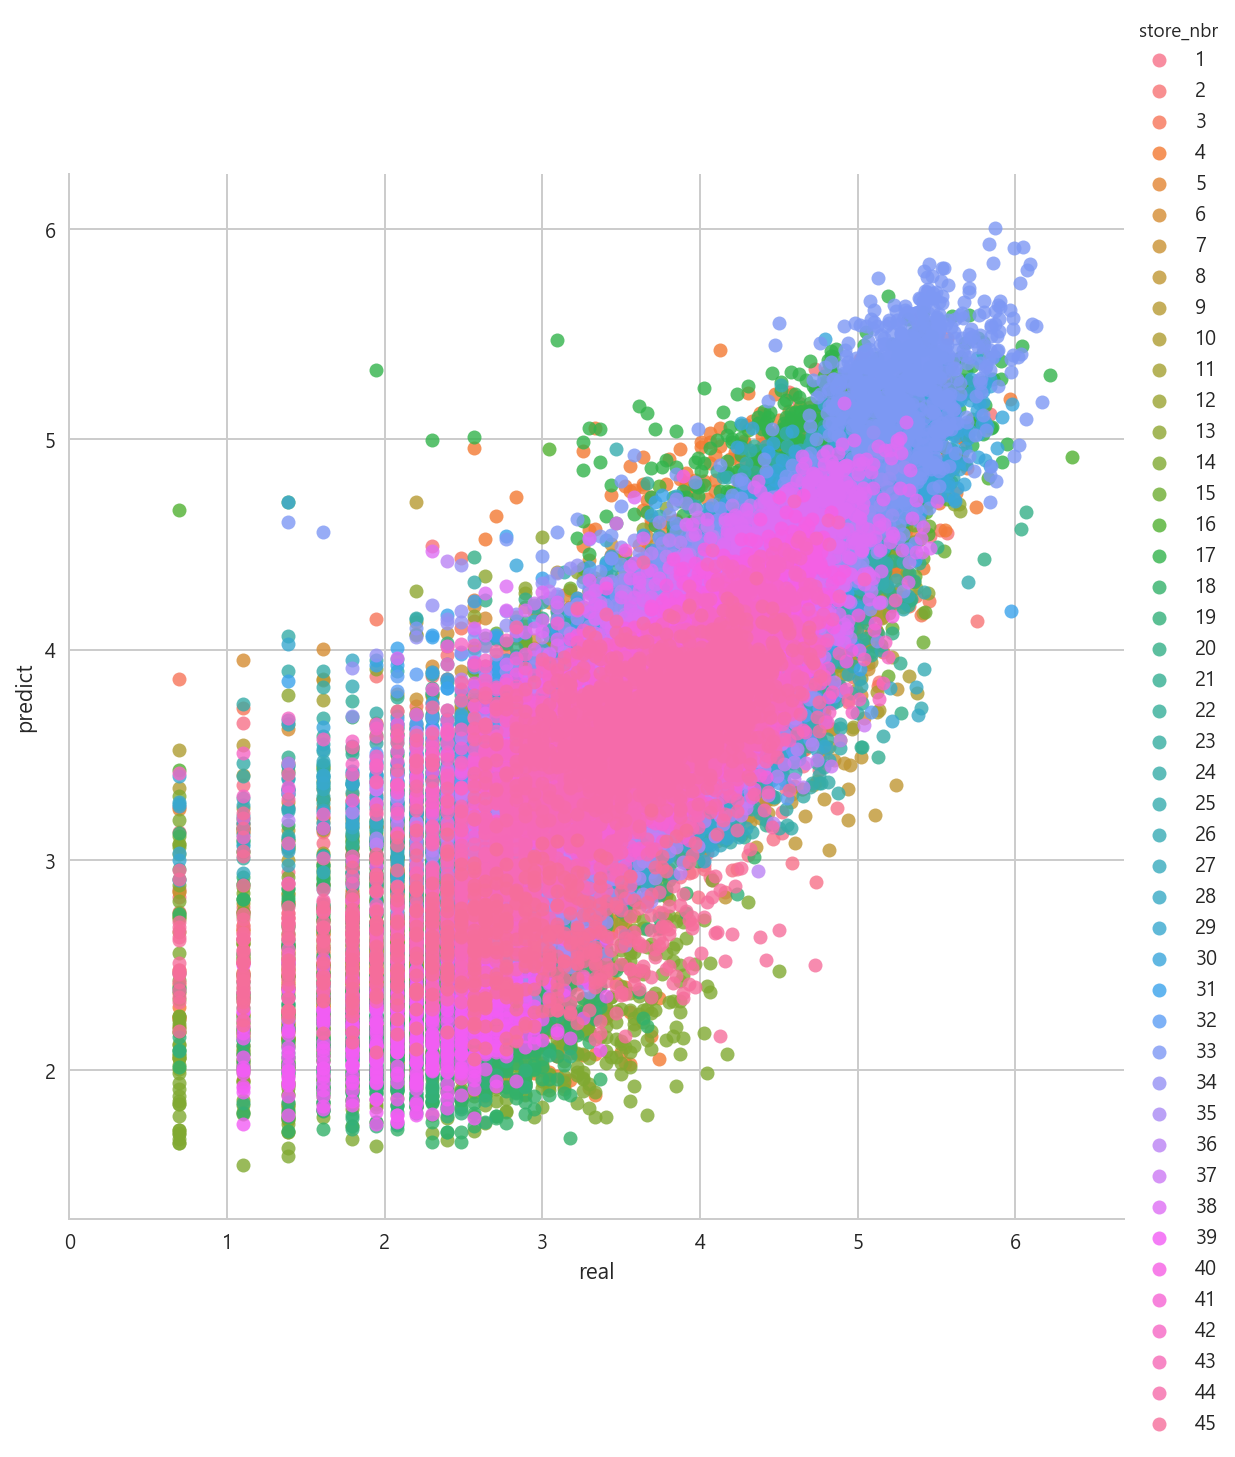

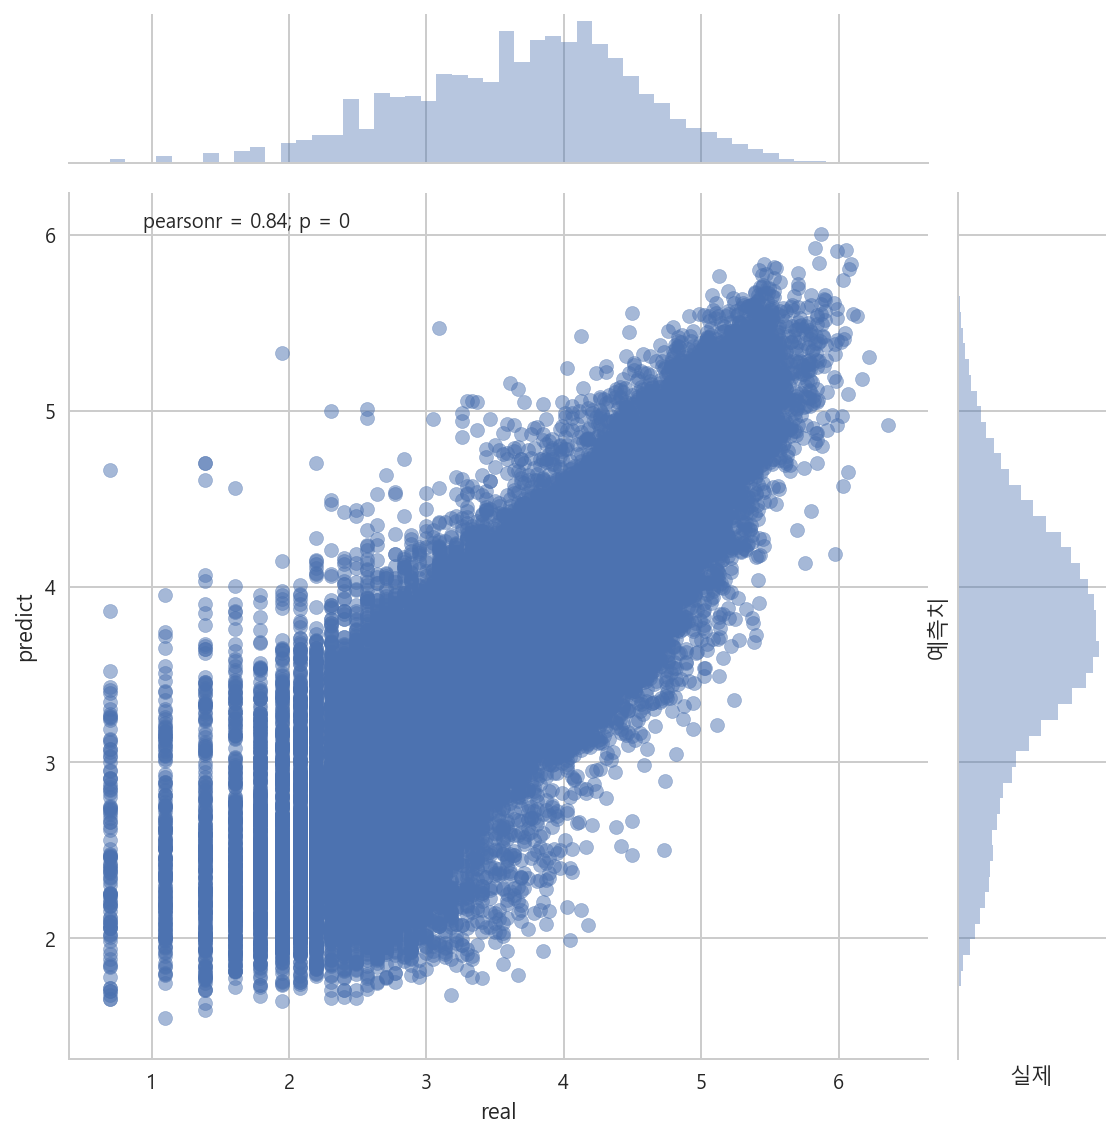

In [31]:
XXX = X_test

predictions = result.predict(XXX)

# 0구간 강제로 제로예측화
# predict_alpha = fillZeroNullPeriod(predictions,X_test)


da = pd.DataFrame()
da["real"]=np.log(XXX["units"]+1)#X_test["units"]
da["predict"]= predictions#predict_alpha #np.e**predictions-1
da["item_nbr"]=XXX["item_nbr"]
da["store_nbr"]=XXX["store_nbr"]
da["DOW"]=XXX["DOW"]


findname = "store_nbr"

dat = da[(da['item_nbr']!=0)&(da[findname]>=1)&(da[findname]<46)]

g= sns.lmplot(data=dat, x="real", y="predict", hue=findname, size = 8, fit_reg=False)

g.set(xlim=(0, None))

k= sns.jointplot(data=dat, x="real", y="predict", size = 8, alpha=0.5)

plt.xlabel(u"실제")
plt.ylabel(u"예측치")
plt.show()


# 교차검증준비

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

scores = np.zeros(10)
rand_st = 103

for i in range(1,len(scores)+1):
    print("교차검증", i ,"차 : ", end ="")
    
    X_train, X_test, y_train, y_test = train_test_split(dfT.iloc[:,1:],\
                                                        dfT.units, test_size=0.30, random_state=i*2018*rand_st)
    formula = "np.log(units**3+1) ~ C(item_nbr) + C(store_nbr) + C(year) + C(month) + C(day) + C(week_day_name) + C(hardrain) + C(hardsnow) + 0"
    
    print("데이터 분류완료 " '데이터 적용/계산중...', end ="")
    
    model = sm.OLS.from_formula(formula=formula, data=X_train)
    # # model = sm.Logit.from_formula(formula=formula, data=X_train)
    result = model.fit()
    y_pred = result.predict(X_test)
    
    print("완료! 채점중...", end ="")
    y_test2=np.log(y_test**3+1)
    scores[i-1] = r2_score(y_test2, y_pred)
    print(scores[i-1])

scores

교차검증 1 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.686113475385
교차검증 2 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.691543490671
교차검증 3 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.688781971987
교차검증 4 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.691526980712
교차검증 5 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.689036461606
교차검증 6 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.693835934143
교차검증 7 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.690723000955
교차검증 8 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.690826804429
교차검증 9 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.686568375241
교차검증 10 차 : 데이터 분류완료 데이터 적용/계산중...완료! 채점중...0.69002244414


array([ 0.68611348,  0.69154349,  0.68878197,  0.69152698,  0.68903646,
        0.69383593,  0.690723  ,  0.6908268 ,  0.68656838,  0.69002244])

In [ ]:
# from patsy import dmatrix

# # 독립변수와 종속변수로 나누기
# df2_1_target = df2_1['log1p_units']
# df2_1_X = df2_1.drop(columns=['log1p_units'])

# len(df2_1_X), len(df2_1_target)

# ##### scikit learn에서 적용할 때 사용하는 코드 :df2_1(log1p_units) 대상

# formula = 'scale(heat) + scale(cool)\
#       + scale(preciptotal) + scale(resultspeed)  \
#       + C(year) + C(month) + scale(relative_humility) + C(weekend) \
#       + C(rainY) + C(store_nbr) + C(item_nbr) + 0'
# dfX = dmatrix(formula, df2_1_X, return_type='dataframe')
# dfy = pd.DataFrame(df2_1_target, columns=["log1p_units"])

# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import KFold
# from sklearn.metrics import r2_score

# model = LinearRegression()
# cv = KFold(10)

# scores = np.zeros(10)
# for i, (train_index, test_index) in enumerate(cv.split(dfX)):
#   X_train = dfX.values[train_index]
#   y_train = dfy.values[train_index]
#   X_test = dfX.values[test_index]
#   y_test = dfy.values[test_index]
#   model.fit(X_train, y_train)
#   y_pred = model.predict(X_test)
#   scores[i] = r2_score(y_test, y_pred)

# 아웃라이어, 레버리지

In [ ]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
# g=sns.lmplot(data=da, x="real", y="predict", size = 8, order=1)
# g.set(xlim=(1.4, None))

idx = hat > 0.05

X_train.units[idx]
Xa=X_train["units"]**0.30
plt.scatter(Xa, predictions)
plt.scatter(Xa[idx], predictions[idx], s=300, c="r", alpha=0.5)

In [ ]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

In [ ]:
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(predictions) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]
plt.figure(figsize=(8,8))
ax = plt.subplot()
# plt.scatter(Xa, predictions)
plt.scatter(Xa[idx], predictions[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(Xa[idx], predictions[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()
idx

# 리지, 라쏘 엘라스틱

In [ ]:
def plot_statsmodels(result):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    dfxx = pd.DataFrame(xx, columns=["x"])
    dfxx = sm.add_constant(dfxx)
    plt.plot(xx, result.predict(dfxx).values)
    plt.show()

In [ ]:
result2 = model.fit_regularized(alpha=0.01, L1_wt=0.5)
print(result2.params)
plot_statsmodels(result2) 

# 기간별 아이템 판매상황

In [ ]:
df[df.item_nbr == 46].pivot(index = "date", columns = "store_nbr", values = "units").plot(figsize=(16,4))


In [ ]:
df[df.item_nbr == 47].pivot(index = "date", columns = "store_nbr", values = "units").plot(figsize=(16,4))

# 캐글데이터 측정 및 Y헷 값 예측

In [ ]:
predf = result.predict(dfT)

In [26]:
# test['date'] = pd.to_datetime(test['date'])

test_a = test.copy()

X_train['units'] = predictions

test_a = test_a.merge(X_train, how='left')


# test_a = test_a.iloc[:526917,:]

test_a.fillna(0, inplace=False)


# test




# X_train["y_hat"] = result.predict(X_train)

# test_df = pd.read_csv("test.csv")

# test_df.item_nbr = test_df.item_nbr.astype(str)
# test_df.store_nbr = test_df.store_nbr.astype(str)
# test_df.date = test_df.astype(str)
# test_df.date = test_df.astype(str)

# final_df_sub = X_train[["date","store_nbr","item_nbr","y_hat"]]
# final_df_sub.item_nbr = final_df_sub.item_nbr.astype(str)
# final_df_sub.store_nbr = final_df_sub.store_nbr.astype(str)
# final_df_sub.date = final_df_sub.date.astype(str)

# final_df_sub.y_hat = np.exp(X_train.y_hat) - 1
# final_df_sub.y_hat.where(final_df_sub.y_hat >= 0, 0)
# pd.merge(test_df,final_df_sub, how = "outer")

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,weekend1,weekend2,weekend3,hardrain,hardsnow,log_units,log_units_std,log_units_mean,z_log_units,z_under-2


In [ ]:
X_train["y_hat"] = result.predict(X_train)
# test_df = pd.read_csv("test.csv")

In [ ]:
final_df_sub = X_train[["date","store_nbr","item_nbr","y_hat"]]
final_df_sub.item_nbr = final_df_sub.item_nbr.astype(object)
final_df_sub.store_nbr = final_df_sub.store_nbr.astype(object)
final_df_sub.date = final_df_sub.date.astype(str).apply(lambda x : x[:10])

final_df_sub.y_hat = np.exp(X_train.y_hat) - 1
final_df_sub.y_hat.where(final_df_sub.y_hat >= 0, 0)
pd.merge(test_df,final_df_sub, how = "outer").fillna(0)

In [ ]:
## af = final_df_sub


test_a = test
test_a['units'] = 0

test_a.item_nbr = test_a.item_nbr.astype(object)
test_a.store_nbr = test_a.store_nbr.astype(object)
test_a.date = test_a.astype(str).apply(lambda x : x[:10])



af = af.sort_values(["date","store_nbr","item_nbr"])
af
temp = 0
klim = len(af['y_hat'])
for i in range(0,len(af['y_hat'])): #predictions
    k=temp
    print(i,"/",k," ",end="")
    
    while 1:
        if k >= klim :
            break
        elif (test_a.iloc[k,0]==af.iloc[i,0])&(test_a.iloc[k,1]==af.iloc[i,1])&(test_a.iloc[k,2]==af.iloc[i,2]):
            temp = k
            test_a.iloc[k,3] = af.iloc[i,3]
            break
        elif (test_a.iloc[i,0]==af.iloc[k,0])&(test_a.iloc[i,1]<af.iloc[k,1])&(test_a.iloc[i,2]<af.iloc[k,2]):
            break
        k += 1
        
test_a['units'] = np.exp(test_a['units'])-1

In [ ]:
af.iloc[0,1]

In [ ]:
# sum(test_a["units"])
test_a.dtypes


In [ ]:
submissiondf = pd.read_csv('sampleSubmission.csv')
submissiondf["units"] = test_a['units']
submissiondf
submissiondf.to_csv('submission_B.csv', index=False)

In [ ]:
#판매중단기간 잘라내기
# df_b = cutForeBehindPeriod(df)
# df_b=df
# set(list(test_a["item_nbr"]))
test_a.columns